### This analysis is based on the pull aligned continuous bhv variables and neural activity analysis
### The goal of this code is to define DHHM model and test the hypothesis that social gaze before pull serves as a evidence accumulation process, and test if the neural profile matches the accumulation hypothesis

In [1]:
import numpy as np
import pandas as pd # Added import for Pandas

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as st
import scipy.io
from scipy.stats import pearsonr

import hddm
import pymc as pm # Explicitly import pymc for summary function
import arviz as az # Explicitly import arviz for summary function


from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# from dPCA import dPCA
import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import sys
import os
import glob
import random
from time import time


In [3]:
# !pip install lifelines
from lifelines import CoxPHFitter


In [4]:
# to be able to use the functions in the ana_functions under /3d_recontruction_analysis_self_and_coop_task_neural_analysis/
sys.path.append(os.path.abspath('../3d_recontruction_analysis_self_and_coop_task_neural_analysis/'))

### function - get body part location for each pair of cameras

In [5]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [6]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [7]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [8]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [9]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [10]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.plot_continuous_bhv_var_singlecam import plot_continuous_bhv_var_singlecam
from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [11]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [12]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [13]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [14]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR import plot_bhv_events_aligned_FR
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [15]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - HDDM related function

In [33]:
from functions._apply_gaussian_burst import _apply_gaussian_burst
from functions.generate_marmoset_pull_data import generate_marmoset_pull_data # create simulated data
from functions.compute_stats import compute_stats
from functions.align_and_plot_data import align_and_plot_data
from functions.get_aligned_segment import get_aligned_segment
from functions.analyze_pull_aligned_data import analyze_pull_aligned_data
from functions.analyze_pull_aligned_data_flexibleTW import analyze_pull_aligned_data_flexibleTW
from functions.analyze_pull_aligned_data_flexibleTW_newRTdefinition import analyze_pull_aligned_data_flexibleTW_newRTdefinition

from functions.run_hddm_modeling import run_hddm_modeling
from functions.run_hddm_modeling_exaustModel import run_hddm_modeling_exaustModel
from functions.run_hddm_modeling_bhvPCA import run_hddm_modeling_bhvPCA

# from functions.run_hddmnn_modeling import run_hddmnn_modeling # do not work
from functions.do_hddm_model_fitted_plot import do_hddm_model_fitted_plot


### function - other useful functions

In [17]:
# for defining the meaningful social gaze (the continuous gaze distribution that is closest to the pull) 
from ana_functions.keep_closest_cluster_single_trial import keep_closest_cluster_single_trial

In [18]:
# get more information for each pull: number of preceding failed pull and time since last reward/successful pull
from ana_functions.get_pull_infos import get_pull_infos


## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [98]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0',# 'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', # 'kanga', 
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson',# 'Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', # 'Kanga', 
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     # '20231101_Dodson_withGinger_SR',
                                     # '20231107_Dodson_withGinger_SR',
                                     # '20231122_Dodson_withGinger_SR',
                                     # '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            # 'SR',
                            # 'SR',
                            # 'SR',
                            # 'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      # "20231101_SR",
                      # "20231107_SR",
                      # "20231122_SR",
                      # "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 # 0.00,   
                                 # 0.00,  
                                 # 0.00,  
                                 # 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         # 2, 
                         # 2, 
                         # 4, 
                         # 4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorders = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorders = ['ginger']*np.shape(dates_list)[0]

        animal1_filenames = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filenames = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

# totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
# # location of the estimiated middle of the box
lever_locs_camI = {'dodson':np.array([1325,615]),'scorch':np.array([560,615])}
# # location of the estimated lever
# lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # old
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define hddm data summarizing data set    
hddm_datas_all_dates = dict.fromkeys(dates_list, [])
hddm_datas_flexibleTW_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
# data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'
# data_saved_folder = '/Users/weikangshi/Downloads/MishaCode_temp/'
data_saved_folder = ''

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [99]:
print(np.shape(neural_record_conditions))
print(np.shape(task_conditions))
print(np.shape(dates_list))
print(np.shape(videodates_list)) 
print(np.shape(session_start_times))

print(np.shape(kilosortvers))

print(np.shape(trig_channelnames))
print(np.shape(animal1_fixedorders)) 
print(np.shape(recordedanimals))
print(np.shape(animal2_fixedorders))

print(np.shape(animal1_filenames))
print(np.shape(animal2_filenames))  

(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)


In [100]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # dummy 
    
    #
    print('loading all data')
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/hddm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        hddm_datas_all_dates = pickle.load(f)
   
    with open(data_saved_subfolder+'/hddm_datas_flexibleTW_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        hddm_datas_flexibleTW_all_dates = pickle.load(f)        
        
    with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        hddm_datas_flexibleTW_newRTdefinition_all_dates = pickle.load(f)   
        
    print('all data from all dates are loaded')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]

        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
    
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]

        
        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
            
        # define successful pulls and failed pulls
        # a new definition of successful and failed pulls
        # separate successful and failed pulls
        # step 1 all pull and juice
        time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
        time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
        time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
        time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
        # step 2:
        # pull 1
        # Find the last pull before each juice
        successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
        # Convert to Pandas Series
        successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
        # pull 2
        # Find the last pull before each juice
        successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
        # Convert to Pandas Series
        successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
        # Find failed pulls (pulls that are not successful)
        failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
        #
        # step 3:
        time_point_pull1_succ = np.round(successful_pull1,1)
        time_point_pull2_succ = np.round(successful_pull2,1)
        time_point_pull1_fail = np.round(failed_pull1,1)
        time_point_pull2_fail = np.round(failed_pull2,1)
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
        
        # 
        # based on time point pull and juice, define some features for each pull action
        pull_infos = get_pull_infos(animal1, animal2, time_point_pull1, time_point_pull2, 
                                    time_point_juice1, time_point_juice2)
        
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.ceil(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
        
        #
        # organize variables that are required by the HDDM functions
        # load the data first, if not process and then save the data 
        print('prepare the data for HDDM')
        try:
            # dummy
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_hddm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            with open(add_date_dir+'/hddm_data.pkl', 'rb') as f:
                hddm_data = pickle.load(f)
            with open(add_date_dir+'/hddm_data_flexibleTW.pkl', 'rb') as f:
                hddm_data_flexibleTW = pickle.load(f)
            with open(add_date_dir+'/hddm_data_flexibleTW_newRT.pkl', 'rb') as f:
                hddm_data_flexibleTW_newRT = pickle.load(f)
        except:
            print('no HDDM data, analyze it and save it')
            #
            gausKernelsize = 4
            #
            # clean the data
            time_point_pull1 = np.array(time_point_pull1)+session_start_time
            time_point_pull1 = time_point_pull1[time_point_pull1<totalsess_time]
            time_point_pull2 = np.array(time_point_pull2)+session_start_time
            time_point_pull2 = time_point_pull2[time_point_pull2<totalsess_time]
            #
            time_point_juice1 = np.array(time_point_juice1)+session_start_time
            time_point_juice1 = time_point_juice1[time_point_juice1<totalsess_time]
            time_point_juice2 = np.array(time_point_juice2)+session_start_time
            time_point_juice2 = time_point_juice2[time_point_juice2<totalsess_time]
            #
            oneway_gaze1 = np.sort(np.hstack((oneway_gaze1,mutual_gaze1)))
            animal1_gaze = oneway_gaze1
            animal1_gaze = np.sort(np.unique(animal1_gaze))+session_start_time
            #
            oneway_gaze2 = np.sort(np.hstack((oneway_gaze2,mutual_gaze2)))
            animal2_gaze = oneway_gaze2
            animal2_gaze = np.sort(np.unique(animal2_gaze))+session_start_time
            #
            # organize the data into a time series
            pull1_data = np.zeros([int(totalsess_time*fps),])
            pull1_data[np.round(time_point_pull1*fps).astype(int)]=1
            #
            pull2_data = np.zeros([int(totalsess_time*fps),])
            pull2_data[np.round(time_point_pull2*fps).astype(int)]=1
            #
            juice1_data = np.zeros([int(totalsess_time*fps),])
            juice1_data[np.round(time_point_juice1*fps).astype(int)]=1
            #
            juice2_data = np.zeros([int(totalsess_time*fps),])
            juice2_data[np.round(time_point_juice2*fps).astype(int)]=1
            #
            gaze1_data = np.zeros([int(totalsess_time*fps),])
            gaze1_data[np.round(animal1_gaze*fps).astype(int)]=1
            gaze1_data = scipy.ndimage.gaussian_filter1d(gaze1_data,gausKernelsize)
            #
            gaze2_data = np.zeros([int(totalsess_time*fps),])
            gaze2_data[np.round(animal2_gaze*fps).astype(int)]=1
            gaze2_data = scipy.ndimage.gaussian_filter1d(gaze2_data,gausKernelsize)
            #
            facemass1 = output_key_locations['facemass_loc_all_merge']['dodson'].transpose()
            facemass1 = np.hstack((facemass1,[[np.nan],[np.nan]]))
            at1_min_at0 = (facemass1[:,1:]-facemass1[:,:-1])
            speed1_data = np.sqrt(np.einsum('ij,ij->j', at1_min_at0, at1_min_at0))*fps 
            speed1_data = scipy.ndimage.gaussian_filter1d(speed1_data,gausKernelsize)
            #
            facemass2 = output_key_locations['facemass_loc_all_merge']['scorch'].transpose()
            facemass2 = np.hstack((facemass2,[[np.nan],[np.nan]]))
            at1_min_at0 = (facemass2[:,1:]-facemass2[:,:-1])
            speed2_data = np.sqrt(np.einsum('ij,ij->j', at1_min_at0, at1_min_at0))*fps 
            speed2_data = scipy.ndimage.gaussian_filter1d(speed2_data,gausKernelsize)
            #
            # get the data that can be used for the HDDM pipeline
            # also plot the correlation 
            time_window_start_s=-4 # same setting as in the other analysis pipeline
            time_window_end_s=0
            coop_window = 1
            resolution = 1/fps
            #
            if np.isin(animal1,animal1_fixedorder):
                hddm_data = analyze_pull_aligned_data(pull1_data, pull2_data, gaze1_data, gaze2_data, 
                                                     speed1_data, speed2_data, resolution, time_window_start_s, 
                                                     time_window_end_s, coop_window)

                hddm_data_flexibleTW = analyze_pull_aligned_data_flexibleTW(pull1_data, pull2_data, 
                                                                           gaze1_data, gaze2_data, 
                                                                           speed1_data, speed2_data, resolution, 
                                                                           time_window_start_s, time_window_end_s, 
                                                                           coop_window)
                
                hddm_data_flexibleTW_newRT = analyze_pull_aligned_data_flexibleTW_newRTdefinition(pull1_data, pull2_data, 
                                                                           juice1_data, juice2_data,
                                                                           gaze1_data, gaze2_data, 
                                                                           speed1_data, speed2_data, resolution, 
                                                                           time_window_start_s, time_window_end_s, 
                                                                           coop_window)
            else:
                hddm_data = analyze_pull_aligned_data(pull2_data, pull1_data, gaze2_data, gaze1_data, 
                                                     speed2_data, speed1_data, resolution, time_window_start_s, 
                                                     time_window_end_s, coop_window)

                hddm_data_flexibleTW = analyze_pull_aligned_data_flexibleTW(pull2_data, pull1_data, 
                                                                           gaze2_data, gaze1_data, 
                                                                           speed2_data, speed1_data, resolution, 
                                                                           time_window_start_s, time_window_end_s, 
                                                                           coop_window)
                
                hddm_data_flexibleTW_newRT = analyze_pull_aligned_data_flexibleTW_newRTdefinition(pull2_data, pull1_data, 
                                                                           juice2_data, juice1_data,
                                                                           gaze2_data, gaze1_data, 
                                                                           speed2_data, speed1_data, resolution, 
                                                                           time_window_start_s, time_window_end_s, 
                                                                           coop_window)
            
            #
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody_with_hddm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(add_date_dir+'/hddm_data.pkl', 'wb') as f:
                pickle.dump(hddm_data, f)
            with open(add_date_dir+'/hddm_data_flexibleTW.pkl', 'wb') as f:
                pickle.dump(hddm_data_flexibleTW, f)
            with open(add_date_dir+'/hddm_data_flexibleTW_newRT.pkl', 'wb') as f:
                pickle.dump(hddm_data_flexibleTW_newRT, f)
      
        #    
        hddm_datas_all_dates[date_tgt] = hddm_data
        hddm_datas_flexibleTW_all_dates[date_tgt] = hddm_data_flexibleTW
        hddm_datas_flexibleTW_newRTdefinition_all_dates[date_tgt] = hddm_data_flexibleTW_newRT
        
        
            
        # # #     
        # load and organize neural related data   
        # # # 
            
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)     
        
        # 
        # # load spike sorting results
        if 0:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            # spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            #
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
                                                                                          spike_clusters_data, spike_time_data)
            # _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
            #                                                                              spike_channels_data, spike_time_data)                     
            
            #
            # Run PCA analysis
            FR_zscore_allch_np_merged = np.array(pd.DataFrame(FR_zscore_allch).T)
            FR_zscore_allch_np_merged = FR_zscore_allch_np_merged[~np.isnan(np.sum(FR_zscore_allch_np_merged,axis=1)),:]
            # # run PCA on the entire session
            pca = PCA(n_components=3)
            FR_zscore_allch_PCs = pca.fit_transform(FR_zscore_allch_np_merged.T)
           
            
 

    # save data
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/hddm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_newRTdefinition_all_dates, f) 
            
    
    # only save a subset 
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        with open(data_saved_subfolder+'/hddm_datas_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_all_dates, f) 
        with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(hddm_datas_flexibleTW_newRTdefinition_all_dates, f) 
     
   
    

loading all data
all data from all dates are loaded


### fit the HDDM model for all the data, copy this part and following to the Misha later when HDDM pipeline is installed successfully

In [101]:
# 
animal_tgt = 'kanga' # 'kanga','kanga_partner','dodson','dodson_partner'
# animal_tgt = 'dodson'

#
# conditions_to_ana = np.unique(task_conditions)
###
# For Kanga
conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', ] # all MC
# conditions_to_ana = [ 'MC_withVermelho']
# conditions_to_ana = ['SR', 'SR_withDodson', ] # all SR
# conditions_to_ana = ['MC', 'MC_withDodson', 'MC_withVermelho', ] # MC with male
# conditions_to_ana = ['MC_withGinger', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', ] # MC with familiar male
# conditions_to_ana = ['MC_withGinger', ] # MC with familiar female
# conditions_to_ana = ['MC_withDodson', 'MC_withVermelho', ] # MC with unfamiliar male
# conditions_to_ana = ['MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_DannonAuto'] # partner AL
# conditions_to_ana = ['MC_KangaAuto'] # self AL
# conditions_to_ana = ['NV','NV_withDodson'] # NV
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho', 
#                      'SR', 'SR_withDodson',]
###
# For Dodson
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # all MC
# conditions_to_ana = ['MC', 'MC_withKanga', ] # all MC
# conditions_to_ana = ['SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ] # all SR
# conditions_to_ana = ['MC', 'MC_withKanga', 'MC_withKoala', ] # all MC, no gingerNew
# conditions_to_ana = ['SR', 'SR_withKanga', 'SR_withKoala', ] # all SR,  no gingerNew
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', ] # MC with female
# conditions_to_ana = ['MC', 'MC_withGingerNew', ] # MC with familiar female
# conditions_to_ana = ['MC_withKanga', 'MC_withKoala', ] # MC with unfamiliar female
# conditions_to_ana = ['MC_KoalaAuto_withKoala'] # partner AL
# conditions_to_ana = ['MC_DodsonAuto_withKoala'] # self AL
# conditions_to_ana = ['NV_withKanga'] # NV
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 
#                      'SR', 'SR_withGingerNew', 'SR_withKanga', 'SR_withKoala', ]


# cond_toplot_type = 'allSR'
cond_toplot_type = 'allMC'
# cond_toplot_type =  'MC_withVermelho'

# make sure to only look certain condition, and keep things consistent
ind_tgt = list(np.isin(task_conditions,conditions_to_ana))

animal1_fixedorders_toana = list(np.array(animal1_fixedorders)[ind_tgt])
animal2_fixedorders_toana = list(np.array(animal2_fixedorders)[ind_tgt])
task_conditions_toana = list(np.array(task_conditions)[ind_tgt])

dates_to_ana = list(np.array(dates_list)[ind_tgt])
ndates_to_ana = np.shape(dates_to_ana)[0]

In [102]:
# do the hddm fitting for all sessions separately
# not in use because the reaction time definition is outdated
if 0:

    dofixTW = 0 # 0: not do the fixed TW, instead use the flexible TW (from one pull to another); 1: do the fixed tw (-4s to 0s)
    doflexTW_newRT = 1 # 1: do the flexible TW with new definition of RT
    #
    if dofixTW:
        fixTW_sufix = '_fixedTW'
    elif not dofixTW:
        if not doflexTW_newRT:
            fixTW_sufix = ''
        elif doflexTW_newRT:
            fixTW_sufix = '_flexTW_newRT'
    
    # HDDM settings - the basic setting
    samples=250 # 2000
    burn=100
    thin=1
    
    # keep the regression r and p between gaze_accum and diffusion slope v
    corr_gazeaccum_driftv = np.ones((ndates_to_ana,))*np.nan
    p_gazeaccum_driftv = np.ones((ndates_to_ana,))*np.nan

    for idate in np.arange(0,ndates_to_ana,1):
    # for idate in np.arange(3,4,1):

        date_toana = dates_to_ana[idate]
        
        task_condition_toana = task_conditions_toana[idate]
        
        animal1_fixedorder = [animal1_fixedorders_toana[idate]]
        animal2_fixedorder = [animal2_fixedorders_toana[idate]]

        try:
            # try to load the data first
            try:
                current_dir = data_saved_folder+'bhv_events_singlecam_wholebody_with_hddm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                add_date_dir = os.path.join(current_dir,cameraID+'/'+date_toana)
                #
                with open(add_date_dir+'/hddm_model_fitted_traces'+fixTW_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_traces = pickle.load(f)
                with open(add_date_dir+'/hddm_model_fitted_nogaze_traces'+fixTW_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_nogaze_traces = pickle.load(f)
                
                with open(add_date_dir+'/hddm_model_fitted_stats'+fixTW_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_stats = pickle.load(f)
                with open(add_date_dir+'/hddm_model_fitted_nogaze_stats'+fixTW_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_nogaze_stats = pickle.load(f)
                    
                with open(add_date_dir+'/hddm_model_fitted_dic'+fixTW_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_dic = pickle.load(f)
                with open(add_date_dir+'/hddm_model_fitted_nogaze_dic'+fixTW_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_nogaze_dic = pickle.load(f)
                    
                if dofixTW:
                    with open(add_date_dir+'/hddm_data.pkl', 'rb') as f:
                        hddm_data_tgt_idate = pickle.load(f)
                elif not dofixTW:
                    if not doflexTW_newRT:
                        with open(add_date_dir+'/hddm_data_flexibleTW.pkl', 'rb') as f:
                            hddm_data_tgt_idate = pickle.load(f)
                    elif doflexTW_newRT:
                        with open(add_date_dir+'/hddm_data_flexibleTW_newRT.pkl', 'rb') as f:
                            hddm_data_tgt_idate = pickle.load(f)
                #
                hddm_data_tgt_idate = hddm_data_tgt_idate['hddm_data_'+animal_id_toana]
                                                         
                        
                print(animal_tgt+' '+date_toana+' hddm fitting results loaded')

            # do the hddm model fitting
            except:

                print(animal_tgt+' '+date_toana+' running hddm fitting')

                if np.isin(animal_tgt,animal1_fixedorders[idate]):
                    animal_id_toana = 'animal1'
                elif np.isin(animal_tgt,animal2_fixedorders[idate]):
                    animal_id_toana = 'animal2'

                # # use the fixed -4s to 0s time window
                if dofixTW:
                    hddm_data = hddm_datas_all_dates[date_toana]
                # use the flexible time window setting
                elif not dofixTW:
                    hddm_data = hddm_datas_flexibleTW_all_dates[date_toana]
                    
                hddm_data_tgt_idate = hddm_data['hddm_data_'+animal_id_toana]

                    
                # run the hddm nodel - to fix the problem, use a lazy methods
                try:
                    hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_idate, 
                                                                                animal_id_toana, samples, burn, thin)
                except:
                    samples=500 # 2000
                    burn=100
                    thin=2  
                    hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_idate, 
                                                                                animal_id_toana, samples, burn, thin)

                #
                hddm_model_fitted_traces = hddm_model_fitted.get_traces()
                hddm_model_fitted_stats  = hddm_model_fitted.gen_stats()
                hddm_model_fitted_dic = hddm_model_fitted.dic_info
                #
                hddm_model_fitted_nogaze_traces = hddm_model_fitted_nogaze.get_traces()
                hddm_model_fitted_nogaze_stats  = hddm_model_fitted_nogaze.gen_stats()
                hddm_model_fitted_nogaze_dic = hddm_model_fitted_nogaze.dic_info

                # save data
                if 1:
                    current_dir = data_saved_folder+'bhv_events_singlecam_wholebody_with_hddm_model/'+animal1_fixedorder[0]+animal2_fixedorder[0]
                    add_date_dir = os.path.join(current_dir,cameraID+'/'+date_toana)
                    if not os.path.exists(add_date_dir):
                        os.makedirs(add_date_dir)
                    #
                    with open(add_date_dir+'/hddm_model_fitted_traces'+fixTW_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_traces, f)
                    with open(add_date_dir+'/hddm_model_fitted_nogaze_traces'+fixTW_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_nogaze_traces, f)
                    
                    with open(add_date_dir+'/hddm_model_fitted_stats'+fixTW_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_stats, f)
                    with open(add_date_dir+'/hddm_model_fitted_nogaze_stats'+fixTW_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_nogaze_stats, f)
                        
                    with open(add_date_dir+'/hddm_model_fitted_dic'+fixTW_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_dic, f)
                    with open(add_date_dir+'/hddm_model_fitted_nogaze_dic'+fixTW_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_nogaze_dic, f)
                        
                        
            # do some plotting
            if 0:
                df_combined = hddm_data_tgt_idate
                #
                # traces = hddm_model_fitted_traces
                traces = hddm_model_fitted_nogaze_traces
                #
                # Get the mean value for the intercept
                v_intercept_mean = traces['v_Intercept'].mean()
                #
                # Get the mean value for the coefficient of each predictor
                # v_gaze_coef_mean = traces['v_self_gaze_auc'].mean()
                v_speed_coef_mean = traces['v_partner_mean_speed'].mean()
                v_failed_pulls_before_reward_mean = traces['v_failed_pulls_before_reward'].mean()
                v_time_since_last_reward_mean = traces['v_time_since_last_reward'].mean()
                #
                print(f"Mean v_Intercept: {v_intercept_mean:.3f}")
                # print(f"Mean v_self_gaze_auc Coef: {v_gaze_coef_mean:.3f}")
                print(f"Mean v_partner_mean_speed Coef: {v_speed_coef_mean:.3f}")
                print(f"Mean v_failed_pulls_before_reward Coef: {v_failed_pulls_before_reward_mean:.3f}")
                print(f"Mean v_time_since_last_reward Coef: {v_time_since_last_reward_mean:.3f}")
                #
                # --- STEP 2: Apply the regression equation to your dataframe ---
                # This calculates the predicted 'v' for each trial based on its unique covariate values.
                df_with_v = df_combined.copy() # Work with a copy
                #
                df_with_v['predicted_v'] = (v_intercept_mean +
                                              # (v_gaze_coef_mean * df_with_v['self_gaze_auc']) +
                                              (v_speed_coef_mean * df_with_v['partner_mean_speed'])+
                                              (v_failed_pulls_before_reward_mean * df_with_v['failed_pulls_before_reward'])+
                                              (v_time_since_last_reward_mean * df_with_v['time_since_last_reward']))

                #!!! Add some criteria for plotting
                # ind_good1 = (df_with_v['self_gaze_auc']>=0) & (df_with_v['self_gaze_auc']<=1)
                # ind_good2 = df_with_v['predicted_v']<3
                # df_with_v = df_with_v[ind_good1 & ind_good2]
                #
                fig, r_vals, p_vals = do_hddm_model_fitted_plot(df_with_v)
                #
                corr_gazeaccum_driftv[idate] = r_vals
                p_gazeaccum_driftv[idate] = p_vals

        except:
            continue
    

In [103]:
# combine the target sessions together, then run the hddm fitting
# not in use because the reaction time definition is outdated

if 0:

    dofixTW = 0 # 0: not do the fixed TW, instead use the flexible TW (from one pull to another); 1: do the fixed tw (-4s to 0s)
    doflexTW_newRT = 1 # 1: do the flexible TW with new definition of RT
    #
    if dofixTW:
        fixTW_sufix = '_fixedTW'
    elif not dofixTW:
        if not doflexTW_newRT:
            fixTW_sufix = ''
        elif doflexTW_newRT:
            fixTW_sufix = '_flexTW_newRT'
        
    # only run the noselfgaze hddm fitting
    doNogazeOnly = 0
    
    # use more variables for v a and z
    doExaustModel = 0
    if doExaustModel:
        exaustModel_sufix = '_exaustModel'
    elif not doExaustModel:
        exaustModel_sufix = ''
        
        
    # try to load the data first
    try:
        
        # dummpy
        
        current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
        add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession')
        #
        if not doNogazeOnly:
            with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_traces = pickle.load(f)
            
            with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_stats = pickle.load(f)
            
            with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_dic = pickle.load(f)
        #
        with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_traces = pickle.load(f)
        
        with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_stats = pickle.load(f)
        
        with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_dic = pickle.load(f)
            
        with open(add_date_dir+'/hddm_data_tgt_alldates_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)

        print(animal_tgt+' '+cond_toplot_type+' hddm fitting results loaded')

    # do the hddm model fitting    
    except:
        print(animal_tgt+' '+cond_toplot_type+' running hddm fitting')
        
        for idate in np.arange(0,ndates_to_ana,1):
        # for idate in np.arange(3,4,1):

            date_toana = dates_to_ana[idate]
            
            task_condition_toana = task_conditions_toana[idate]

            animal1_fixedorder = [animal1_fixedorders_toana[idate]]
            animal2_fixedorder = [animal2_fixedorders_toana[idate]]
    

            if np.isin(animal_tgt,animal1_fixedorders[idate]):
                animal_id_toana = 'animal1'
            elif np.isin(animal_tgt,animal2_fixedorders[idate]):
                animal_id_toana = 'animal2'

            # # use the fixed -4s to 0s time window
            if dofixTW:
                hddm_data = hddm_datas_all_dates[date_toana]
            # us the flexible time window setting
            elif not dofixTW:
                if not doflexTW_newRT:
                    hddm_data = hddm_datas_flexibleTW_all_dates[date_toana]
                # use the new RT definition
                if doflexTW_newRT:
                    hddm_data = hddm_datas_flexibleTW_newRTdefinition_all_dates[date_toana]

            hddm_data_tgt_idate = hddm_data['hddm_data_'+animal_id_toana]
            
            # add a date column and task condition column
            hddm_data_tgt_idate['date'] = date_toana
            hddm_data_tgt_idate['condition'] = task_condition_toana       
            
            #
            if idate == 0:
                hddm_data_tgt_alldates = hddm_data_tgt_idate
            else:
                hddm_data_tgt_alldates = pd.concat([hddm_data_tgt_alldates, hddm_data_tgt_idate])
              
            
        # # add some semi-artbitrary cretieras
        # hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['prev_trial_outcome']==1]
        # hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['partner_mean_speed']<=300]
        #
        lower_q = 0.05
        upper_q = 0.95
        rt_lower, rt_upper = hddm_data_tgt_alldates['rt'].quantile([lower_q, upper_q])
        hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']>rt_lower]
        hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']<rt_upper]
        #
        tslr_lower, tslr_upper = hddm_data_tgt_alldates['time_since_last_reward'].quantile([lower_q, upper_q])
        hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['time_since_last_reward']>tslr_lower]
        hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['time_since_last_reward']<tslr_upper]
            
        # 
        # remove nan row first
        hddm_data_tgt_alldates = hddm_data_tgt_alldates.dropna()
        
        # 
        # normalize all the predictors
        from scipy.stats import zscore
        #
        # List of predictor columns to normalize (exclude 'rt' and identifiers)
        predictor_columns = [
            'self_gaze_auc',
            'partner_mean_speed',
            'self_mean_speed',
            'partner_speed_std',
            'self_speed_std',
            'failed_pulls_before_reward',
            'time_since_last_reward'
        ]
        # Rename originals and replace with z-scored values
        for col in predictor_columns:
            hddm_data_tgt_alldates[f"{col}_origin"] = hddm_data_tgt_alldates[col]
            hddm_data_tgt_alldates[col] = zscore(hddm_data_tgt_alldates[col])  
            
            
        # run the hddm nodel
        if not doExaustModel:
            # HDDM settings - the basic setting
            # samples=500 # 2000
            # burn=100
            # thin=2
            samples=1000 # 2000
            burn=100
            thin=2
            #
            if not doNogazeOnly:
                hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_alldates, animal_id_toana,
                                                                            samples, burn, thin, doNogazeOnly)
            elif doNogazeOnly:
                _, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_alldates, animal_id_toana,
                                                                            samples, burn, thin, doNogazeOnly)
                
        elif doExaustModel:
            # samples=2000 # 2000
            # burn=1000
            # thin=4
            samples=200 # 2000
            burn=100
            thin=2
            #
            if not doNogazeOnly:
                hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling_exaustModel(hddm_data_tgt_alldates, animal_id_toana, 
                                                                            samples, burn, thin, doNogazeOnly)
            elif doNogazeOnly:
                _, hddm_model_fitted_nogaze = run_hddm_modeling_exaustModel(hddm_data_tgt_alldates, animal_id_toana,
                                                                            samples, burn, thin, doNogazeOnly)

        #
        if not doNogazeOnly:
            hddm_model_fitted_traces = hddm_model_fitted.get_traces()
            hddm_model_fitted_stats  = hddm_model_fitted.gen_stats()
            hddm_model_fitted_dic = hddm_model_fitted.dic_info
        #
        hddm_model_fitted_nogaze_traces = hddm_model_fitted_nogaze.get_traces()
        hddm_model_fitted_nogaze_stats  = hddm_model_fitted_nogaze.gen_stats()
        hddm_model_fitted_nogaze_dic = hddm_model_fitted_nogaze.dic_info

        # save data
        if 1:
            current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
            add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession')
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            if not doNogazeOnly:
                with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_traces, f)
            
                with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_stats, f)
               
                with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_dic, f)
            
            #
            with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_model_fitted_nogaze_traces, f)
            
            with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_model_fitted_nogaze_stats, f)  
            
            with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_model_fitted_nogaze_dic, f)

            with open(add_date_dir+'/hddm_data_tgt_alldates_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_data_tgt_alldates, f)
      
    
    #
    # do some plotting
    if 1:
        df_combined = hddm_data_tgt_alldates  # your combined trial-level dataframe
        traces = hddm_model_fitted_nogaze_traces  # or use `hddm_model_fitted_traces` if needed
        stats = hddm_model_fitted_nogaze_stats

        # --- STEP 1: Use all posterior samples to compute predicted v for each trial ---
        n_samples = len(traces)
        n_trials = len(df_combined)

        # Allocate space to hold predicted v for each sample x trial
        predicted_v_samples = np.zeros((n_samples, n_trials))

        # Pre-fetch covariate values as numpy arrays
        x1 = df_combined['partner_mean_speed'].values
        x2 = df_combined['partner_speed_std'].values
        x3 = df_combined['self_mean_speed'].values
        x4 = df_combined['self_speed_std'].values
        # x3 = df_combined['failed_pulls_before_reward'].values
        # x3 = df_combined['time_since_last_reward'].values

        for i in range(n_samples):
            intercept = traces['v_Intercept'].values[i]
            coef_x1 = traces['v_partner_mean_speed'].values[i]
            coef_x2 = traces['v_partner_speed_std'].values[i]
            coef_x3 = traces['v_self_mean_speed'].values[i]
            coef_x4 = traces['v_self_speed_std'].values[i]
            # coef_x3 = traces['v_failed_pulls_before_reward'].values[i]
            # coef_x3 = traces['v_time_since_last_reward'].values[i]

            # Apply regression formula for all trials
            predicted_v_samples[i, :] = (
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3
                # intercept + coef_x1 * x1 
                # intercept + coef_x1 * x1 + coef_x3 * x3
                intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4
                
                
            )

        # --- STEP 2: Compute posterior mean (and optionally CI) of predicted v ---
        df_with_v = df_combined.copy()
        df_with_v['predicted_v'] = predicted_v_samples.mean(axis=0)

        # Optional: also store credible intervals (e.g., 95% CI)
        df_with_v['predicted_v_lower'] = np.percentile(predicted_v_samples, 2.5, axis=0)
        df_with_v['predicted_v_upper'] = np.percentile(predicted_v_samples, 97.5, axis=0)        
        
        
        # df_with_v['self_gaze_auc'] = df_with_v['self_gaze_auc'] * df_with_v['rt']
        
        #
        #!!! Add some criteria for plotting
        #
        # remove dodson with gingerNew and Koala
        # ind_bad = (df_with_v['condition']=='MC_withGingerNew') | (df_with_v['condition']=='MC_withKoala')
        # df_with_v = df_with_v[~ind_bad]
        
        
        # Define quantile thresholds
        lower_q = 0.05
        upper_q = 0.95
        # Compute quantile-based limits
        gaze_lower, gaze_upper = df_with_v['self_gaze_auc'].quantile([lower_q, upper_q])
        v_lower, v_upper = df_with_v['predicted_v'].quantile([lower_q, upper_q])
        # Filter out outliers
        ind_good = (
            # (df_with_v['self_gaze_auc'] >= gaze_lower) & (df_with_v['self_gaze_auc'] <= gaze_upper) &
            (df_with_v['predicted_v'] >= v_lower) & (df_with_v['predicted_v'] <= v_upper)
        )
        #
        # df_with_v = df_with_v[ind_good]
        
        fig, r_vals, p_vals = do_hddm_model_fitted_plot(df_with_v)
        
        # savefig
        savefig = 1
        if savefig:
            current_dir = data_saved_folder+'fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_hddm_model/'+animal_tgt
            add_fig_dir = os.path.join(current_dir,cameraID+'/fig_for_hddm_model_fitted_combinedsession')
            #
            if not os.path.exists(add_fig_dir):
                os.makedirs(add_fig_dir)
            
            fig.savefig(add_fig_dir+'/gaze_accum_vs_driftslopev_'+cond_toplot_type+fixTW_sufix+exaustModel_sufix+'.pdf', 
                        format='pdf', bbox_inches='tight')

            
            
            
        
        # do the plotting separating different conditions (different pairs)
        conds_toplot = np.unique(df_with_v['condition'])
        nconds_toplot = np.shape(conds_toplot)[0]
        
        for icond_toplot in np.arange(0,nconds_toplot,1):
            
            ind_toplot = df_with_v['condition']==conds_toplot[icond_toplot]
            
            fig_i, r_vals_i, p_vals_i = do_hddm_model_fitted_plot(df_with_v[ind_toplot])
            
            ax = fig_i.axes[0]
            ax.set_title(conds_toplot[icond_toplot]+
                        ' Deming Regression: Self-Gaze vs Predicted Drift Rate (v)', fontsize=14)
            
            # savefig
            savefig = 1
            if savefig:
                current_dir = data_saved_folder+'fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_hddm_model'+savefile_sufix+'/'+animal_tgt
                add_fig_dir = os.path.join(current_dir,cameraID+'/fig_for_hddm_model_fitted_combinedsession')
                #
                if not os.path.exists(add_fig_dir):
                    os.makedirs(add_fig_dir)

                fig_i.savefig(add_fig_dir+'/gaze_accum_vs_driftslopev_'+conds_toplot[icond_toplot]+fixTW_sufix+exaustModel_sufix+'.pdf', 
                            format='pdf', bbox_inches='tight')
        
    

kanga allMC hddm fitting results loaded
Regression Statistics:
Pearson's r: 0.5050
p-value: 0.0000
Deming slope: 1.4533
Deming intercept: -2.7803
Regression Statistics:
Pearson's r: 0.5789
p-value: 0.0000
Deming slope: 1.7897
Deming intercept: -3.3183
Regression Statistics:
Pearson's r: 0.4898
p-value: 0.0000
Deming slope: 1.1373
Deming intercept: -2.0511
Regression Statistics:
Pearson's r: 0.5604
p-value: 0.0000
Deming slope: 1.6182
Deming intercept: -3.3404
Regression Statistics:
Pearson's r: 0.6351
p-value: 0.0000
Deming slope: 2.5086
Deming intercept: -5.1466
Regression Statistics:
Pearson's r: 0.0978
p-value: 0.3029
Deming slope: 0.2808
Deming intercept: -0.4747


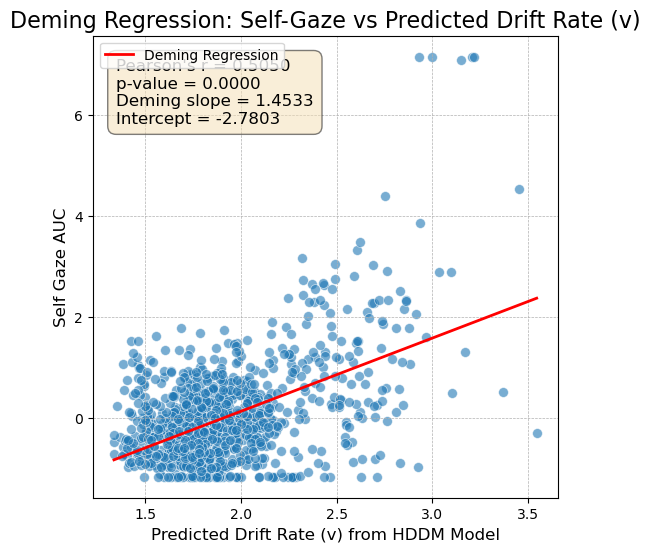

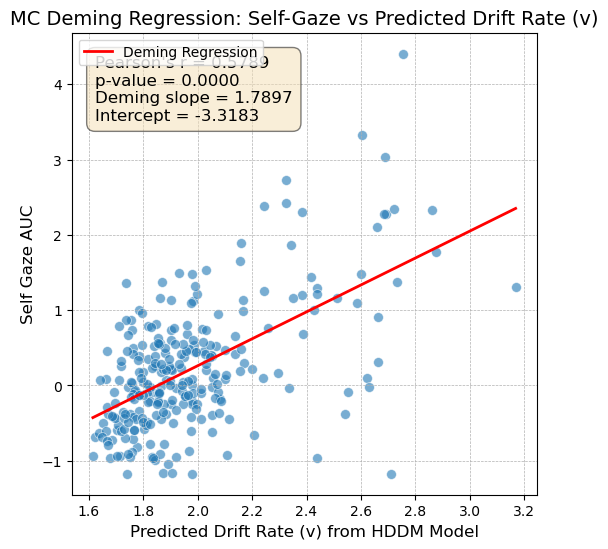

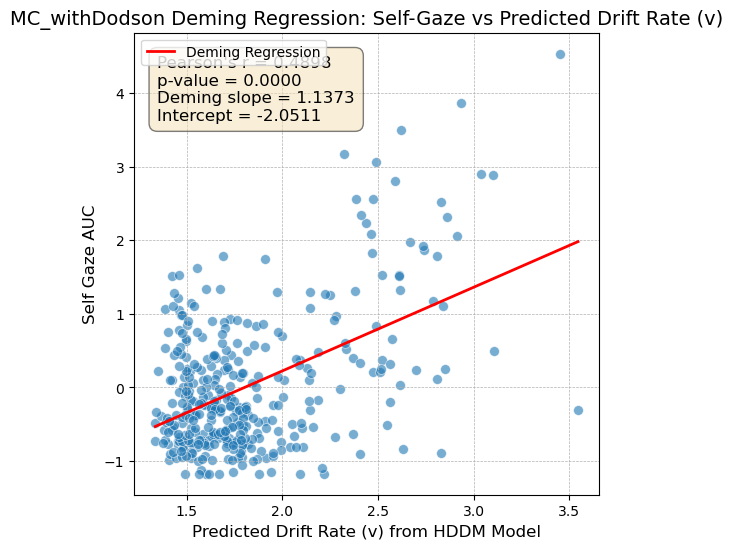

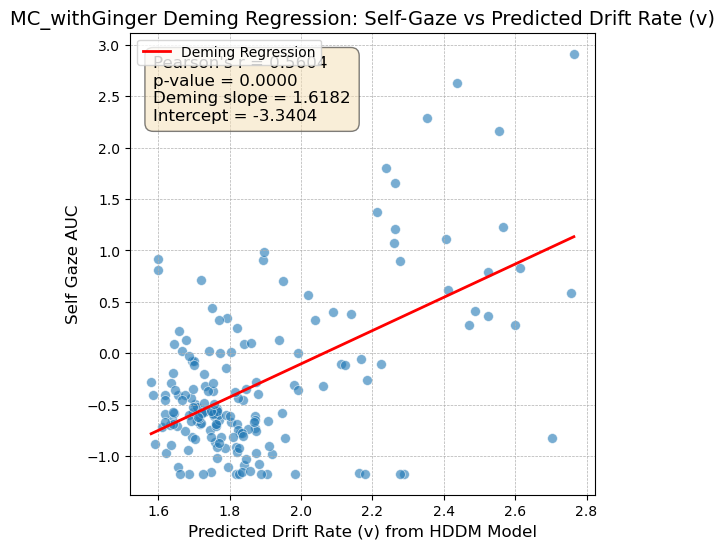

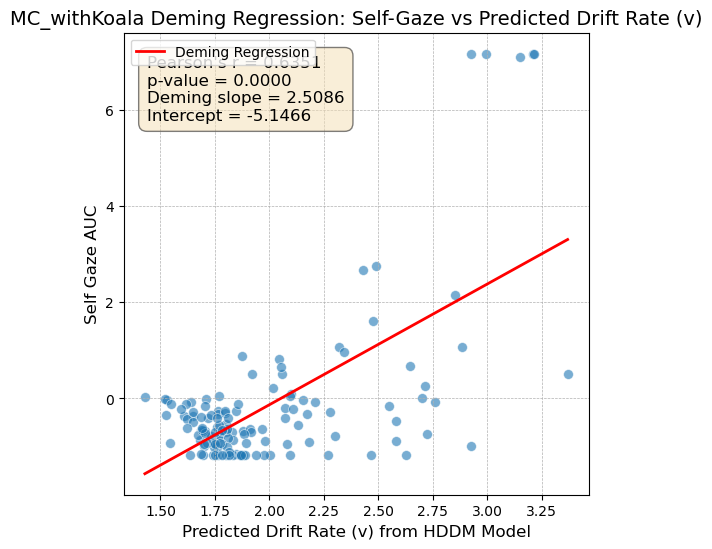

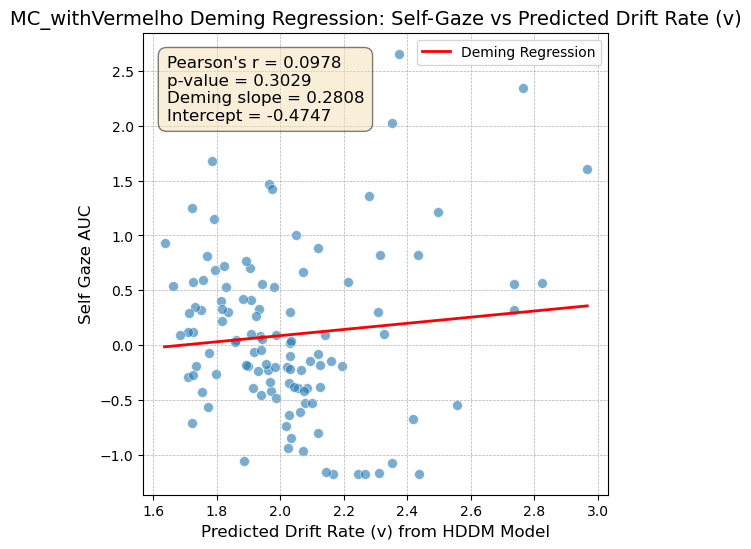

In [104]:
# run the hddm fitting using the data set that contained average neuron activity (across neurons for each trial)
# the data set is calculated in Misha - basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartToPull_section_continuousBhv

if 1:
    
    # In this data set all the rt is calculated using the new definition, but the pull onset is defined slightly different
    #
    # if use the bhv PCA
    dobhvPCA = 1
    if not dobhvPCA:
        # if use onset of the first increase after min
        doOnsetAfterMin = 1
        if not doOnsetAfterMin:
            doOnsetAfterMin_suffix = ''
        elif doOnsetAfterMin:
            doOnsetAfterMin_suffix = 'PullOnsetAfterMin_'
    elif dobhvPCA:
        # if use onset of the first increase after min
        doOnsetAfterMin = 1
        doBasedonSpeed = 1
        if not doOnsetAfterMin:
            doOnsetAfterMin_suffix = 'bhvPCA_'
        elif doOnsetAfterMin:
            if not doBasedonSpeed:
                doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMin_'
            elif doBasedonSpeed:
                doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMinBasedonSpeed_'

    # if use a hmm based method to find the trial start
    doHMMmethod = 0
    if doHMMmethod:
        doOnsetAfterMin_suffix = 'HMMmethods_'
        
        
    # only run the noselfgaze hddm fitting
    doNogazeOnly = 0
    
    # use more variables for v a and z
    doExaustModel = 0
    if doExaustModel:
        exaustModel_sufix = '_exaustModel'
    elif not doExaustModel:
        exaustModel_sufix = ''
        
    # load the dataset first
    current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
    add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession_withNeurons')
    
    if not doOnsetAfterMin_suffix == 'bhvPCA_PullOnsetAfterMinBasedonSpeed_':
        with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+doOnsetAfterMin_suffix+'withFRs_all_dates_'+
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)
    #
    elif doOnsetAfterMin_suffix == 'bhvPCA_PullOnsetAfterMinBasedonSpeed_':
        with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+'PullOnsetAfterMin_'+'withFRs_all_dates_'+
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)
        

    # make the hddm_data structure consistent with other code
    ind_goodcond = np.isin(hddm_data_tgt_alldates['condition'],conditions_to_ana)
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[ind_goodcond]

    if not dobhvPCA:
        rename_dict = {
        'act_animal':'subj_idx',
        'dates': 'date',
        'pull_rt': 'rt',
        'previous_pull_outcome': 'prev_trial_outcome',
        'socialgaze_auc': 'self_gaze_auc',
        'mass_move_speed_mean': 'self_mean_speed',
        'mass_move_speed_std': 'self_speed_std',
        'other_mass_move_speed_mean': 'partner_mean_speed',
        'other_mass_move_speed_std': 'partner_speed_std',
        'num_preceding_failpull': 'failed_pulls_before_reward',
        'time_from_last_reward': 'time_since_last_reward',
        }
    elif dobhvPCA:
        rename_dict = {
        'act_animal':'subj_idx',
        'dates': 'date',
        'pull_rt': 'rt',
        'previous_pull_outcome': 'prev_trial_outcome',
        'socialgaze_auc': 'self_gaze_auc',
        'self_PC1_mean': 'self_mean_speed',
        'self_PC1_std': 'self_speed_std',
        'other_PC1_mean': 'partner_mean_speed',
        'other_PC1_std': 'partner_speed_std',
        'num_preceding_failpull': 'failed_pulls_before_reward',
        'time_from_last_reward': 'time_since_last_reward',
        }
        
    # Apply the renaming
    hddm_data_tgt_alldates = hddm_data_tgt_alldates.rename(columns=rename_dict)
    hddm_data_tgt_alldates['response'] = 1

    # 
    # remove nan row first
    hddm_data_tgt_alldates = hddm_data_tgt_alldates.dropna()
    
    #
    # # add some semi-artbitrary cretieras
    # hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['prev_trial_outcome']==1]
    # hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['partner_mean_speed']<=300]
    #
    lower_q = 0.05
    upper_q = 0.95
    rt_lower, rt_upper = hddm_data_tgt_alldates['rt'].quantile([lower_q, upper_q])
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']>rt_lower]
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']<rt_upper]
    #
    tslr_lower, tslr_upper = hddm_data_tgt_alldates['time_since_last_reward'].quantile([lower_q, upper_q])
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['time_since_last_reward']>tslr_lower]
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['time_since_last_reward']<tslr_upper]

    # 
    # normalize all the predictors
    from scipy.stats import zscore
    #
    # List of predictor columns to normalize (exclude 'rt' and identifiers)
    predictor_columns = [
        'self_gaze_auc',
        'partner_mean_speed',
        'self_mean_speed',
        'partner_speed_std',
        'self_speed_std',
        'failed_pulls_before_reward',
        'time_since_last_reward'
    ]
    # Rename originals and replace with z-scored values
    for col in predictor_columns:
        hddm_data_tgt_alldates[f"{col}_origin"] = hddm_data_tgt_alldates[col]
        hddm_data_tgt_alldates[col] = zscore(hddm_data_tgt_alldates[col])  
        
    # try to load the analyzed
    try:
        
        # dummpy
        #
        if not doNogazeOnly:
            with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_traces = pickle.load(f)
            
            with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_stats = pickle.load(f)
            
            with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_dic = pickle.load(f)
        #
        with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_traces = pickle.load(f)
        
        with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_stats = pickle.load(f)
        
        with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
            hddm_model_fitted_nogaze_dic = pickle.load(f)
            
        print(animal_tgt+' '+cond_toplot_type+' hddm fitting results loaded')
        
    except:
        
        print(animal_tgt+' '+cond_toplot_type+' running hddm fitting')
            
        # run the hddm nodel
        if not doExaustModel:
            # HDDM settings - the basic setting
            # samples=500 # 2000
            # burn=100
            # thin=2
            samples=200 # 2000
            burn=100
            thin=2
            #
            if not doNogazeOnly:
                hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_alldates, animal_tgt,
                                                                            samples, burn, thin, doNogazeOnly)
            elif doNogazeOnly:
                _, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_alldates, animal_tgt,
                                                                            samples, burn, thin, doNogazeOnly)
                
        elif doExaustModel:
            # samples=2000 # 2000
            # burn=1000
            # thin=4
            samples=200 # 2000
            burn=100
            thin=2
            #
            if not doNogazeOnly:
                hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling_exaustModel(hddm_data_tgt_alldates, animal_tgt, 
                                                                            samples, burn, thin, doNogazeOnly)
            elif doNogazeOnly:
                _, hddm_model_fitted_nogaze = run_hddm_modeling_exaustModel(hddm_data_tgt_alldates, animal_tgt,
                                                                            samples, burn, thin, doNogazeOnly)

        #
        if not doNogazeOnly:
            hddm_model_fitted_traces = hddm_model_fitted.get_traces()
            hddm_model_fitted_stats  = hddm_model_fitted.gen_stats()
            hddm_model_fitted_dic = hddm_model_fitted.dic_info
        #
        hddm_model_fitted_nogaze_traces = hddm_model_fitted_nogaze.get_traces()
        hddm_model_fitted_nogaze_stats  = hddm_model_fitted_nogaze.gen_stats()
        hddm_model_fitted_nogaze_dic = hddm_model_fitted_nogaze.dic_info

        # save data
        if 1:
            current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
            add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession_withNeurons')
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            if not doNogazeOnly:
                with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_traces, f)
            
                with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_stats, f)
               
                with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_dic, f)
            
            #
            with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_model_fitted_nogaze_traces, f)
            
            with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_model_fitted_nogaze_stats, f)  
            
            with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                pickle.dump(hddm_model_fitted_nogaze_dic, f)
            
          
        #
    # do some plotting
    if 1:
        df_combined = hddm_data_tgt_alldates  # your combined trial-level dataframe
        traces = hddm_model_fitted_nogaze_traces  # or use `hddm_model_fitted_traces` if needed
        stats = hddm_model_fitted_nogaze_stats
        # traces = hddm_model_fitted_traces  # or use `hddm_model_fitted_traces` if needed
        # stats = hddm_model_fitted_stats

        # --- STEP 1: Use all posterior samples to compute predicted v for each trial ---
        n_samples = len(traces)
        n_trials = len(df_combined)

        # Allocate space to hold predicted v for each sample x trial
        predicted_v_samples = np.zeros((n_samples, n_trials))

        # Pre-fetch covariate values as numpy arrays
        x1 = df_combined['partner_mean_speed'].values
        x2 = df_combined['partner_speed_std'].values
        x3 = df_combined['self_mean_speed'].values
        x4 = df_combined['self_speed_std'].values
        # x3 = df_combined['failed_pulls_before_reward'].values
        # x3 = df_combined['time_since_last_reward'].values
        # x7 = df_combined['self_gaze_auc'].values

        for i in range(n_samples):
            intercept = traces['v_Intercept'].values[i]
            coef_x1 = traces['v_partner_mean_speed'].values[i]
            coef_x2 = traces['v_partner_speed_std'].values[i]
            coef_x3 = traces['v_self_mean_speed'].values[i]
            coef_x4 = traces['v_self_speed_std'].values[i]
            # coef_x3 = traces['v_failed_pulls_before_reward'].values[i]
            # coef_x3 = traces['v_time_since_last_reward'].values[i]
            # coef_x7 = traces['v_self_gaze_auc'].values[i]

            # Apply regression formula for all trials
            predicted_v_samples[i, :] = (
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3
                # intercept + coef_x1 * x1 
                # intercept + coef_x1 * x1 + coef_x3 * x3
                intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4 + coef_x7 * x7
            )

        # --- STEP 2: Compute posterior mean (and optionally CI) of predicted v ---
        df_with_v = df_combined.copy()
        df_with_v['predicted_v'] = predicted_v_samples.mean(axis=0)

        # Optional: also store credible intervals (e.g., 95% CI)
        df_with_v['predicted_v_lower'] = np.percentile(predicted_v_samples, 2.5, axis=0)
        df_with_v['predicted_v_upper'] = np.percentile(predicted_v_samples, 97.5, axis=0)        
        
        
        # df_with_v['self_gaze_auc'] = df_with_v['self_gaze_auc'] * df_with_v['rt']
        
        #
        #!!! Add some criteria for plotting
        #
        # remove dodson with gingerNew and Koala
        # ind_bad = (df_with_v['condition']=='MC_withGingerNew') | (df_with_v['condition']=='MC_withKoala')
        # df_with_v = df_with_v[~ind_bad]
        
        
        # Define quantile thresholds
        lower_q = 0.05
        upper_q = 0.95
        # Compute quantile-based limits
        gaze_lower, gaze_upper = df_with_v['self_gaze_auc'].quantile([lower_q, upper_q])
        v_lower, v_upper = df_with_v['predicted_v'].quantile([lower_q, upper_q])
        # Filter out outliers
        ind_good = (
            # (df_with_v['self_gaze_auc'] >= gaze_lower) & (df_with_v['self_gaze_auc'] <= gaze_upper) &
            (df_with_v['predicted_v'] >= v_lower) & (df_with_v['predicted_v'] <= v_upper)
        )
        #
        # df_with_v = df_with_v[ind_good]
        
        fig, r_vals, p_vals = do_hddm_model_fitted_plot(df_with_v)
        
        # savefig
        savefig = 1
        if savefig:
            current_dir = data_saved_folder+'fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_hddm_model/'+animal_tgt
            add_fig_dir = os.path.join(current_dir,cameraID+'/fig_for_hddm_model_fitted_combinedsession_withNeurons')
            #
            if not os.path.exists(add_fig_dir):
                os.makedirs(add_fig_dir)
            
            fig.savefig(add_fig_dir+'/gaze_accum_vs_driftslopev_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pdf', 
                        format='pdf', bbox_inches='tight')

            
            
            
        
        # do the plotting separating different conditions (different pairs)
        conds_toplot = np.unique(df_with_v['condition'])
        nconds_toplot = np.shape(conds_toplot)[0]
        
        for icond_toplot in np.arange(0,nconds_toplot,1):
            
            ind_toplot = df_with_v['condition']==conds_toplot[icond_toplot]
            
            fig_i, r_vals_i, p_vals_i = do_hddm_model_fitted_plot(df_with_v[ind_toplot])
            
            ax = fig_i.axes[0]
            ax.set_title(conds_toplot[icond_toplot]+
                        ' Deming Regression: Self-Gaze vs Predicted Drift Rate (v)', fontsize=14)
            
            # savefig
            savefig = 1
            if savefig:
                current_dir = data_saved_folder+'fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_hddm_model'+savefile_sufix+'/'+animal_tgt
                add_fig_dir = os.path.join(current_dir,cameraID+'/fig_for_hddm_model_fitted_combinedsession_withNeurons')
                #
                if not os.path.exists(add_fig_dir):
                    os.makedirs(add_fig_dir)

                fig_i.savefig(add_fig_dir+'/gaze_accum_vs_driftslopev_'+conds_toplot[icond_toplot]+doOnsetAfterMin_suffix+exaustModel_sufix+'.pdf', 
                            format='pdf', bbox_inches='tight')

            
            
    
    
    

In [105]:
doOnsetAfterMin_suffix

'bhvPCA_PullOnsetAfterMinBasedonSpeed_'

kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded


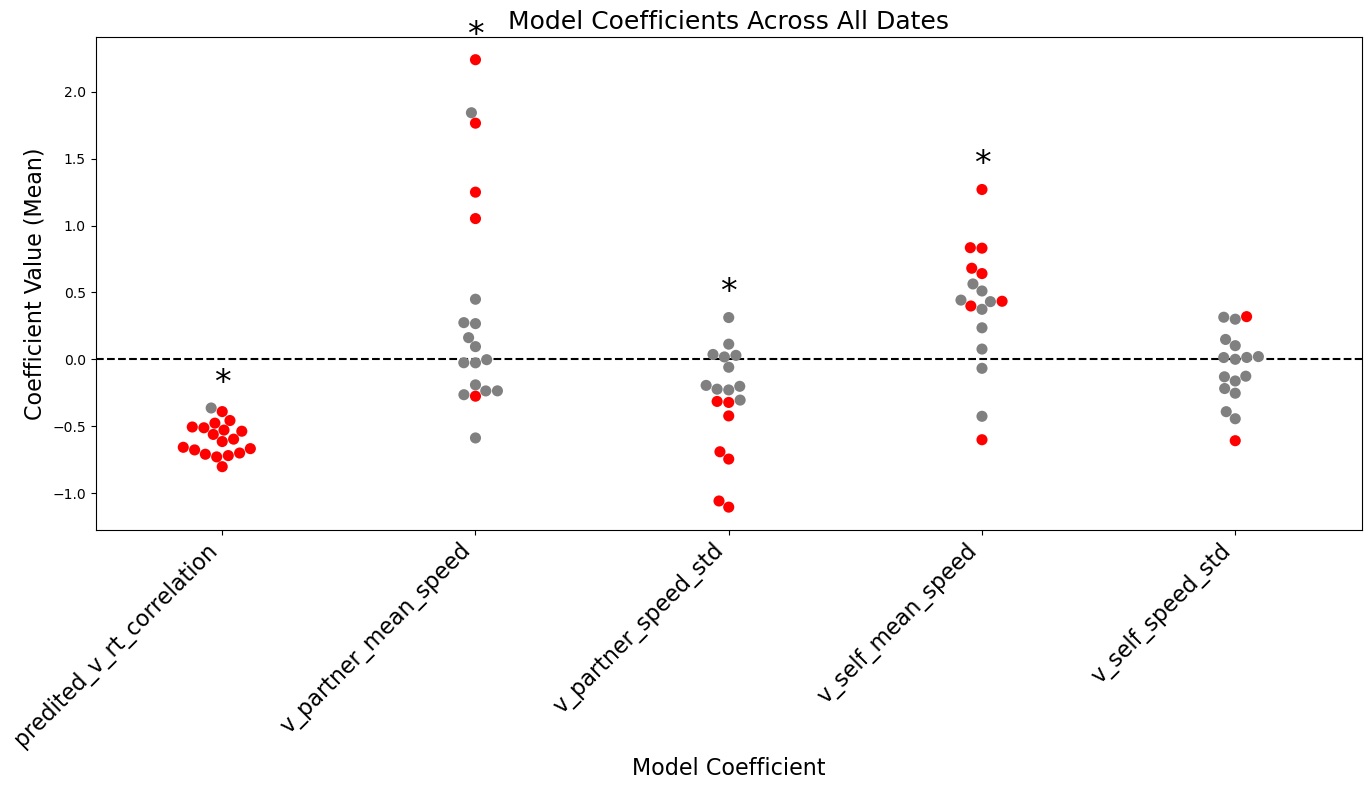

In [106]:
# run the hddm fitting using the data set that contained average neuron activity (across neurons for each trial)
# the data set is calculated in Misha - basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartToPull_section_continuousBhv

# this one is to fit the ddm in each sesssion separately

if 1:
    
    import seaborn as sns
    from scipy.stats import ttest_1samp

    # In this data set all the rt is calculated using the new definition, but the pull onset is defined slightly different
    #
    # if use the bhv PCA
    dobhvPCA = 1
    if not dobhvPCA:
        # if use onset of the first increase after min
        doOnsetAfterMin = 1
        if not doOnsetAfterMin:
            doOnsetAfterMin_suffix = ''
        elif doOnsetAfterMin:
            doOnsetAfterMin_suffix = 'PullOnsetAfterMin_'
    elif dobhvPCA:
        # if use onset of the first increase after min
        doOnsetAfterMin = 1
        doBasedonSpeed = 1
        if not doOnsetAfterMin:
            doOnsetAfterMin_suffix = 'bhvPCA_'
        elif doOnsetAfterMin:
            if not doBasedonSpeed:
                doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMin_'
            elif doBasedonSpeed:
                doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMinBasedonSpeed_'

                
    # if use a hmm based method to find the trial start
    doHMMmethod = 0
    if doHMMmethod:
        doOnsetAfterMin_suffix = 'HMMmethods_'
        
        
    # only run the noselfgaze hddm fitting
    doNogazeOnly = 0
        
    
    # use more variables for v a and z
    doExaustModel = 0
    if doExaustModel:
        exaustModel_sufix = '_exaustModel'
    elif not doExaustModel:
        exaustModel_sufix = ''
        
    # load the dataset first
    current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
    add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession_withNeurons')
    
    if not doOnsetAfterMin_suffix == 'bhvPCA_PullOnsetAfterMinBasedonSpeed_':
        with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+doOnsetAfterMin_suffix+'withFRs_all_dates_'+
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)
    #
    elif doOnsetAfterMin_suffix == 'bhvPCA_PullOnsetAfterMinBasedonSpeed_':
        with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+'PullOnsetAfterMin_'+'withFRs_all_dates_'+
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)

    # make the hddm_data structure consistent with other code
    ind_goodcond = np.isin(hddm_data_tgt_alldates['condition'],conditions_to_ana)
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[ind_goodcond]
    
    if not dobhvPCA:
        rename_dict = {
        'act_animal':'subj_idx',
        'dates': 'date',
        'pull_rt': 'rt',
        'previous_pull_outcome': 'prev_trial_outcome',
        'socialgaze_auc': 'self_gaze_auc',
        'mass_move_speed_mean': 'self_mean_speed',
        'mass_move_speed_std': 'self_speed_std',
        'other_mass_move_speed_mean': 'partner_mean_speed',
        'other_mass_move_speed_std': 'partner_speed_std',
        'num_preceding_failpull': 'failed_pulls_before_reward',
        'time_from_last_reward': 'time_since_last_reward',
        }
    elif dobhvPCA:
        rename_dict = {
        'act_animal':'subj_idx',
        'dates': 'date',
        'pull_rt': 'rt',
        'previous_pull_outcome': 'prev_trial_outcome',
        'socialgaze_auc': 'self_gaze_auc',
        'self_PC1_mean': 'self_mean_speed',
        'self_PC1_std': 'self_speed_std',
        'other_PC1_mean': 'partner_mean_speed',
        'other_PC1_std': 'partner_speed_std',
        'num_preceding_failpull': 'failed_pulls_before_reward',
        'time_from_last_reward': 'time_since_last_reward',
        }
        
    # Apply the renaming
    hddm_data_tgt_alldates = hddm_data_tgt_alldates.rename(columns=rename_dict)
    hddm_data_tgt_alldates['response'] = 1

    # 
    # remove nan row first
    hddm_data_tgt_alldates = hddm_data_tgt_alldates.dropna()

    # 
    # normalize all the predictors
    from scipy.stats import zscore
    #
    # List of predictor columns to normalize (exclude 'rt' and identifiers)
    predictor_columns = [
        'self_gaze_auc',
        'partner_mean_speed',
        'self_mean_speed',
        'partner_speed_std',
        'self_speed_std',
        'failed_pulls_before_reward',
        'time_since_last_reward'
    ]
    # Rename originals and replace with z-scored values
    for col in predictor_columns:
        hddm_data_tgt_alldates[f"{col}_origin"] = hddm_data_tgt_alldates[col]
        hddm_data_tgt_alldates[col] = zscore(hddm_data_tgt_alldates[col])  
      
    #
    # initialize a dataframe for summarizing all sessions results
    summary_list = []
    
    
    # run the fitting for each session
    for session_toana, hddm_data_tgt_idate in hddm_data_tgt_alldates.groupby('date'):
    
        # Inside the loop:
        # 'session_toana' is the date for the current group
        # 'hddm_data_tgt_idate' is a DataFrame containing only the rows for that date
        
        #
        # # add some semi-artbitrary cretieras
        # hddm_data_tgt_alldates = hddm_data_tgt_idate[hddm_data_tgt_alldates['prev_trial_outcome']==1]
        # hddm_data_tgt_alldates = hddm_data_tgt_idate[hddm_data_tgt_alldates['partner_mean_speed']<=300]
        #
        lower_q = 0.05
        upper_q = 0.95
        rt_lower, rt_upper = hddm_data_tgt_idate['rt'].quantile([lower_q, upper_q])
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['rt']>rt_lower]
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['rt']<rt_upper]
        #
        tslr_lower, tslr_upper = hddm_data_tgt_idate['time_since_last_reward'].quantile([lower_q, upper_q])
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['time_since_last_reward']>tslr_lower]
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['time_since_last_reward']<tslr_upper]
    
        # try to load the analyzed
        try:

            # dummpy
            
            current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
            add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_allsession_withNeurons/'+session_toana)

            #
            if not doNogazeOnly:
                with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_traces = pickle.load(f)

                with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_stats = pickle.load(f)

                with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                    hddm_model_fitted_dic = pickle.load(f)
            #
            with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_nogaze_traces = pickle.load(f)

            with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_nogaze_stats = pickle.load(f)

            with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_nogaze_dic = pickle.load(f)
                
            

            print(animal_tgt+' '+cond_toplot_type+' hddm fitting results loaded')

        except:

            print(animal_tgt+' '+cond_toplot_type+' running hddm fitting')
            
            try:
                # run the hddm nodel
                if not doExaustModel:
                    # HDDM settings - the basic setting
                    # samples=500 # 2000
                    # burn=100
                    # thin=2
                    samples=200 # 2000
                    burn=100
                    thin=2
                    #
                    if not doNogazeOnly:
                        hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_idate, animal_tgt,
                                                                                    samples, burn, thin, doNogazeOnly)
                    elif doNogazeOnly:
                        _, hddm_model_fitted_nogaze = run_hddm_modeling(hddm_data_tgt_idate, animal_tgt,
                                                                        samples, burn, thin, doNogazeOnly)

                elif doExaustModel:
                    # samples=2000 # 2000
                    # burn=1000
                    # thin=4
                    samples=200 # 2000
                    burn=100
                    thin=2
                    #
                    if not doNogazeOnly:
                        hddm_model_fitted, hddm_model_fitted_nogaze = run_hddm_modeling_exaustModel(hddm_data_tgt_idate, animal_tgt, 
                                                                                    samples, burn, thin, doNogazeOnly)
                    elif doNogazeOnly:
                        _, hddm_model_fitted_nogaze = run_hddm_modeling_exaustModel(hddm_data_tgt_idate, animal_tgt,
                                                                                    samples, burn, thin, doNogazeOnly)

            except:
                continue
                
            #
            if not doNogazeOnly:
                hddm_model_fitted_traces = hddm_model_fitted.get_traces()
                hddm_model_fitted_stats  = hddm_model_fitted.gen_stats()
                hddm_model_fitted_dic = hddm_model_fitted.dic_info
            #
            hddm_model_fitted_nogaze_traces = hddm_model_fitted_nogaze.get_traces()
            hddm_model_fitted_nogaze_stats  = hddm_model_fitted_nogaze.gen_stats()
            hddm_model_fitted_nogaze_dic = hddm_model_fitted_nogaze.dic_info

            # save data
            if 1:
                current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
                add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_allsession_withNeurons/'+session_toana)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                if not doNogazeOnly:
                    with open(add_date_dir+'/hddm_model_fitted_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_traces, f)

                    with open(add_date_dir+'/hddm_model_fitted_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_stats, f)

                    with open(add_date_dir+'/hddm_model_fitted_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                        pickle.dump(hddm_model_fitted_dic, f)

                #
                with open(add_date_dir+'/hddm_model_fitted_nogaze_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_nogaze_traces, f)

                with open(add_date_dir+'/hddm_model_fitted_nogaze_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_nogaze_stats, f)  

                with open(add_date_dir+'/hddm_model_fitted_nogaze_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_nogaze_dic, f)
            
          
        #
        # reconstruct V
        #
        df_combined = hddm_data_tgt_idate # your combined trial-level dataframe
        traces = hddm_model_fitted_nogaze_traces  # or use `hddm_model_fitted_traces` if needed
        stats = hddm_model_fitted_nogaze_stats
        # traces = hddm_model_fitted_traces  # or use `hddm_model_fitted_traces` if needed
        # stats = hddm_model_fitted_stats

        # --- STEP 1: Use all posterior samples to compute predicted v for each trial ---
        n_samples = len(traces)
        n_trials = len(df_combined)

        # Allocate space to hold predicted v for each sample x trial
        predicted_v_samples = np.zeros((n_samples, n_trials))

        # Pre-fetch covariate values as numpy arrays
        x1 = df_combined['partner_mean_speed'].values
        x2 = df_combined['partner_speed_std'].values
        x3 = df_combined['self_mean_speed'].values
        x4 = df_combined['self_speed_std'].values
        # x3 = df_combined['failed_pulls_before_reward'].values
        # x3 = df_combined['time_since_last_reward'].values
        # x7 = df_combined['self_gaze_auc'].values

        for i in range(n_samples):
            intercept = traces['v_Intercept'].values[i]
            coef_x1 = traces['v_partner_mean_speed'].values[i]
            coef_x2 = traces['v_partner_speed_std'].values[i]
            coef_x3 = traces['v_self_mean_speed'].values[i]
            coef_x4 = traces['v_self_speed_std'].values[i]
            # coef_x3 = traces['v_failed_pulls_before_reward'].values[i]
            # coef_x3 = traces['v_time_since_last_reward'].values[i]
            # coef_x7 = traces['v_self_gaze_auc'].values[i]

            # Apply regression formula for all trials
            predicted_v_samples[i, :] = (
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3
                # intercept + coef_x1 * x1 
                # intercept + coef_x1 * x1 + coef_x3 * x3
                intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4 + coef_x7 * x7
            )

        # --- STEP 2: Compute posterior mean (and optionally CI) of predicted v ---
        df_with_v = df_combined.copy()
        df_with_v['predicted_v'] = predicted_v_samples.mean(axis=0)

        # Optional: also store credible intervals (e.g., 95% CI)
        df_with_v['predicted_v_lower'] = np.percentile(predicted_v_samples, 2.5, axis=0)
        df_with_v['predicted_v_upper'] = np.percentile(predicted_v_samples, 97.5, axis=0) 
            
        
            
        #
        # save the summaring data across date   
        #
        # --- Process the model data ---
        # --- Task 1: Process the HDDM model coefficients (same as before) ---
        stats['significance'] = (stats['2.5q'] * stats['97.5q'] > 0).astype(int)
        session_summary = stats.reset_index().rename(columns={'index': 'coefficient'})
        session_summary['date'] = session_toana
        session_summary = session_summary[['date', 'coefficient', 'mean', 'std', 'significance']]
        summary_list.append(session_summary)


        # --- Task 2: Calculate and add the v-rt correlation ---
        # Calculate the Pearson correlation coefficient and the p-value.
        corr_coef, p_value = st.pearsonr(df_with_v['predicted_v'], df_with_v['rt'])
        #
        # Create a small DataFrame for the correlation result.
        # We use the 'mean' column for the coefficient and 'significance' for the p-value
        # to keep the data structure consistent.
        corr_summary = pd.DataFrame([{
            'date': session_toana,
            'coefficient': 'predited_v_rt_correlation',
            'mean': corr_coef,
            'std': np.nan,  # Standard deviation isn't applicable here
            'significance': (p_value<0.05).astype(int)
        }])
        #
        # Add the correlation result to the list.
        summary_list.append(corr_summary)
        
        # with mean firing rate
        corr_coef, p_value = st.pearsonr(df_with_v['predicted_v'], df_with_v['fr_mean'])
        #
        # Create a small DataFrame for the correlation result.
        # We use the 'mean' column for the coefficient and 'significance' for the p-value
        # to keep the data structure consistent.
        corr_summary = pd.DataFrame([{
            'date': session_toana,
            'coefficient': 'predicted_v_fr_mean_correlation',
            'mean': corr_coef,
            'std': np.nan,  # Standard deviation isn't applicable here
            'significance': (p_value<0.05).astype(int)
        }])
        #
        # Add the correlation result to the list.
        summary_list.append(corr_summary)
        
         # with slope firing rate
        corr_coef, p_value = st.pearsonr(df_with_v['predicted_v'], df_with_v['fr_slope'])
        #
        # Create a small DataFrame for the correlation result.
        # We use the 'mean' column for the coefficient and 'significance' for the p-value
        # to keep the data structure consistent.
        corr_summary = pd.DataFrame([{
            'date': session_toana,
            'coefficient': 'predicted_v_fr_slope_correlation',
            'mean': corr_coef,
            'std': np.nan,  # Standard deviation isn't applicable here
            'significance': (p_value<0.05).astype(int)
        }])
        #
        # Add the correlation result to the list.
        summary_list.append(corr_summary)
    
    
    
    # Combine the list of DataFrames into the final summary DataFrame.
    hddm_model_fitted_alldates_summary = pd.concat(summary_list, ignore_index=True)
    
    ## 
    # do some plotting
    ##
    plot_data = hddm_model_fitted_alldates_summary.copy()
    
    # ---- NEW: Filter out the coefficients you don't want to see ----
    coeffs_to_exclude = ['t', 'z', 'a', 'v_Intercept', 'a_Intercept','a_time_since_last_reward',
                         'predicted_v_fr_mean_correlation','predicted_v_fr_slope_correlation']
    #
    do_v_and_FR = 0
    if do_v_and_FR:
        coeffs_to_exclude = ['t', 'z', 'v_Intercept', 'a_Intercept','a_time_since_last_reward',
                             'v_self_gaze_auc', 'v_partner_mean_speed','v_partner_speed_std',
                             'v_self_mean_speed','v_self_speed_std',]
    #
    plot_data = plot_data[~plot_data['coefficient'].isin(coeffs_to_exclude)]

    plot_data['mean'] = pd.to_numeric(plot_data['mean'], errors='coerce')
    
    # ---- Remove outliers for each coefficient using the IQR method ----
    # For each coefficient, calculate the bounds
    Q1 = plot_data.groupby('coefficient')['mean'].transform(lambda x: x.quantile(0.25))
    Q3 = plot_data.groupby('coefficient')['mean'].transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #
    # Filter out the outliers
    plot_data_no_outliers = plot_data[(plot_data['mean'] >= lower_bound) & (plot_data['mean'] <= upper_bound)]
    # plot_data_no_outliers = plot_data
    #
    plot_data_no_outliers = plot_data_no_outliers.sort_values(by='coefficient')

    
    
    # --- Plotting Code (using the outlier-free data) ---
    plt.figure(figsize=(14, 8))

    # Create the swarm plot
    # We use 'hue' to color points based on the 'significance' column for that date.
    ax = sns.swarmplot(
        x='coefficient',
        y='mean',
        data=plot_data_no_outliers,
        hue='significance',
        palette={0: 'gray', 1: 'red'},  # 0=Not Significant (gray), 1=Significant (red)
        size=8
    )
    # Hide the legend as the colors are intuitive
    ax.get_legend().remove()


    # --- Add Overall Significance Asterisks ---
    unique_coeffs = plot_data_no_outliers['coefficient'].unique()
    for i, coef in enumerate(unique_coeffs):
        coef_data = plot_data_no_outliers[plot_data_no_outliers['coefficient'] == coef]['mean']

        if len(coef_data) > 1:
            t_stat, p_value = ttest_1samp(coef_data, 0, nan_policy='omit')
            if p_value < 0.05:
                y_pos = coef_data.max()
                offset = plot_data_no_outliers['mean'].std() * 0.1
                plt.text(i, y_pos + offset, '*', ha='center', va='bottom', fontsize=24, color='black')

    plt.axhline(y=0, linestyle='--', color='black', linewidth=1.5)            
    
    # --- Finalize and Save Plot ---
    plt.title('Model Coefficients Across All Dates', fontsize=18)
    plt.ylabel('Coefficient Value (Mean)', fontsize=16)
    plt.xlabel('Model Coefficient', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize = 16)
    plt.tight_layout()

     # savefig
    savefig = 1
    if savefig:
        current_dir = data_saved_folder+'fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_hddm_model'+savefile_sufix+'/'+animal_tgt
        add_fig_dir = os.path.join(current_dir,cameraID+'/fig_for_hddm_model_fitted_allsession_withNeurons')
        #
        if not os.path.exists(add_fig_dir):
            os.makedirs(add_fig_dir)
        if not do_v_and_FR:
            plt.savefig(add_fig_dir+'/predicted_v_and_other_bhv_variables_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pdf', 
                        format='pdf', bbox_inches='tight')
        elif do_v_and_FR:
            plt.savefig(add_fig_dir+'/predicted_v_and_FR_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pdf', 
                        format='pdf', bbox_inches='tight')


In [107]:
plot_data_no_outliers['coefficient']

249    predited_v_rt_correlation
93     predited_v_rt_correlation
105    predited_v_rt_correlation
57     predited_v_rt_correlation
117    predited_v_rt_correlation
                 ...            
186             v_self_speed_std
42              v_self_speed_std
30              v_self_speed_std
246             v_self_speed_std
114             v_self_speed_std
Name: coefficient, Length: 90, dtype: object

In [108]:
doOnsetAfterMin_suffix

'bhvPCA_PullOnsetAfterMinBasedonSpeed_'

In [109]:
#hddm_data_tgt_idate

/tmp/ipykernel_450/2042088019.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hddm_data_tgt_alldates['partner_mean_speed'].iloc[itrial] = partner_mean_speed_filtered
/tmp/ipykernel_450/2042088019.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hddm_data_tgt_alldates['partner_speed_std'].iloc[itrial] = partner_std_speed_filtered
/tmp/ipykernel_450/2042088019.py:112: RuntimeWarning: Mean of empty slice
  partner_mean_speed_filtered = np.nanmean(partner_speed_filtered)
/opt/conda/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axi

kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded
kanga allMC hddm fitting results loaded


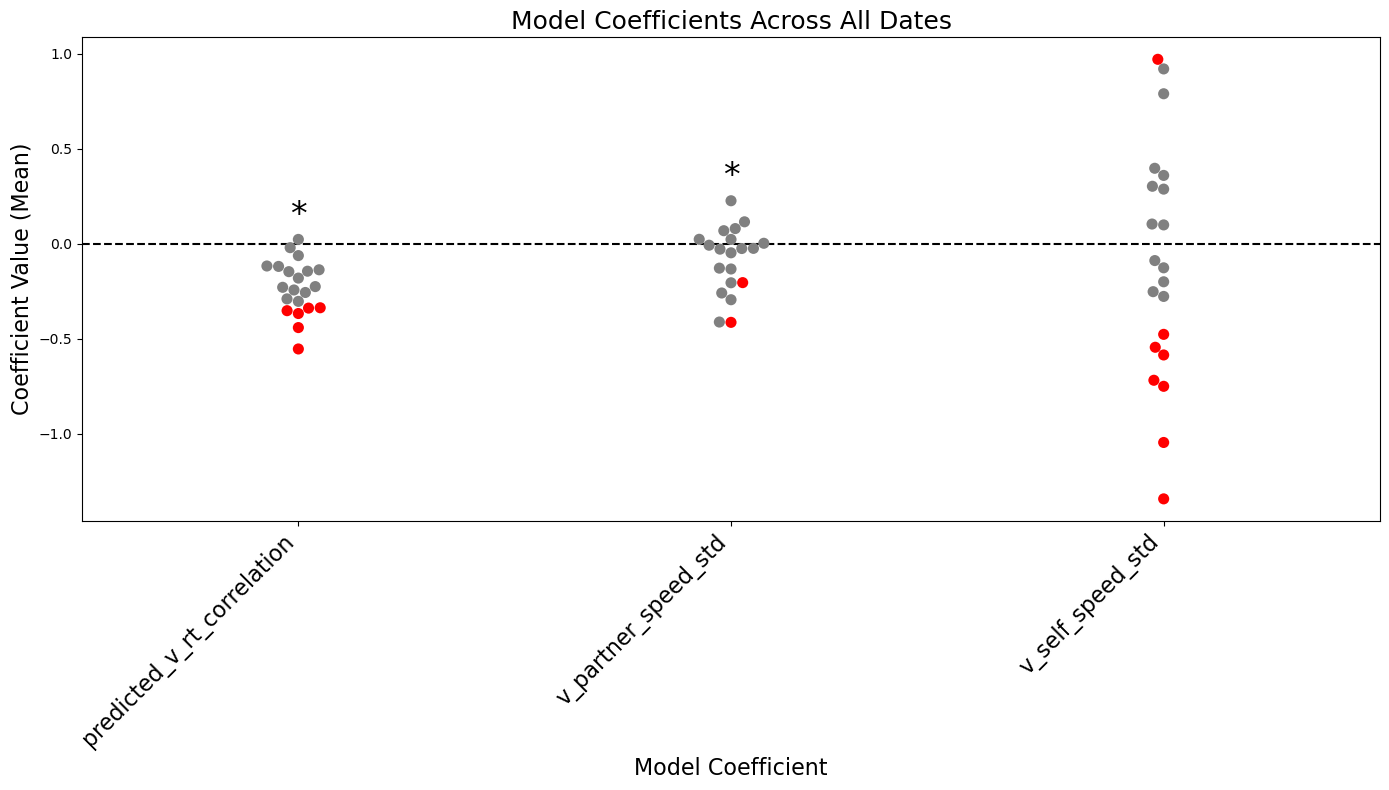

In [110]:
# run the hddm fitting using the data set that contained average neuron activity (across neurons for each trial)
# the data set is calculated in Misha - basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartToPull_section_continuousBhv

# this one is to fit the ddm in each sesssion separately
# this one use gaze period to filter the partner's variables

if 1:
    
    import seaborn as sns
    from scipy.stats import ttest_1samp

    # In this data set all the rt is calculated using the new definition, but the pull onset is defined slightly different
    #
    # if use the bhv PCA
    dobhvPCA = 1
    if not dobhvPCA:
        # if use onset of the first increase after min
        doOnsetAfterMin = 1
        if not doOnsetAfterMin:
            doOnsetAfterMin_suffix = ''
        elif doOnsetAfterMin:
            doOnsetAfterMin_suffix = 'PullOnsetAfterMin_'
    elif dobhvPCA:
        # if use onset of the first increase after min
        doOnsetAfterMin = 1
        doBasedonSpeed = 1
        if not doOnsetAfterMin:
            doOnsetAfterMin_suffix = 'bhvPCA_'
        elif doOnsetAfterMin:
            if not doBasedonSpeed:
                doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMin_'
            elif doBasedonSpeed:
                doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMinBasedonSpeed_'

    # if use a hmm based method to find the trial start
    doHMMmethod = 0
    if doHMMmethod:
        doOnsetAfterMin_suffix = 'HMMmethods_'
        
    exaustModel_sufix = ''
        
    # load the dataset first
    current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
    add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_combinedsession_withNeurons')
    
    if not doOnsetAfterMin_suffix == 'bhvPCA_PullOnsetAfterMinBasedonSpeed_':
        with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+doOnsetAfterMin_suffix+'withFRs_all_dates_'+
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)
    #
    elif doOnsetAfterMin_suffix == 'bhvPCA_PullOnsetAfterMinBasedonSpeed_':
        with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+'PullOnsetAfterMin_'+'withFRs_all_dates_'+
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
            hddm_data_tgt_alldates = pickle.load(f)

    # make the hddm_data structure consistent with other code
    ind_goodcond = np.isin(hddm_data_tgt_alldates['condition'],conditions_to_ana)
    hddm_data_tgt_alldates = hddm_data_tgt_alldates[ind_goodcond]

    if not dobhvPCA:
        rename_dict = {
        'act_animal':'subj_idx',
        'dates': 'date',
        'pull_rt': 'rt',
        'previous_pull_outcome': 'prev_trial_outcome',
        'socialgaze_auc': 'self_gaze_auc',
        'mass_move_speed_mean': 'self_mean_speed',
        'mass_move_speed_std': 'self_speed_std',
        'other_mass_move_speed_mean': 'partner_mean_speed',
        'other_mass_move_speed_std': 'partner_speed_std',
        'num_preceding_failpull': 'failed_pulls_before_reward',
        'time_from_last_reward': 'time_since_last_reward',
        }
    elif dobhvPCA:
        rename_dict = {
        'act_animal':'subj_idx',
        'dates': 'date',
        'pull_rt': 'rt',
        'previous_pull_outcome': 'prev_trial_outcome',
        'socialgaze_auc': 'self_gaze_auc',
        'self_PC1_mean': 'self_mean_speed',
        'self_PC1_std': 'self_speed_std',
        'other_PC1_mean': 'partner_mean_speed',
        'other_PC1_std': 'partner_speed_std',
        'num_preceding_failpull': 'failed_pulls_before_reward',
        'time_from_last_reward': 'time_since_last_reward',
        }
        
    # Apply the renaming
    hddm_data_tgt_alldates = hddm_data_tgt_alldates.rename(columns=rename_dict)
    hddm_data_tgt_alldates['response'] = 1

    
    #
    # calculated the new partner_mean_speed and partner_speed_std with self_gaze filter
    #
    hddm_data_tgt_alldates['partner_speed_std_nofilter'] = hddm_data_tgt_alldates['partner_speed_std']
    hddm_data_tgt_alldates['partner_mean_speed_nofilter'] = hddm_data_tgt_alldates['partner_mean_speed']
    
    #
    ntrials = np.shape(hddm_data_tgt_alldates)[0]
    for itrial in np.arange(0,ntrials,1):
        gaze_prob_itrial = hddm_data_tgt_alldates['socialgaze_prob'].iloc[itrial]
        #
        if not dobhvPCA:
            partner_speed_trial = hddm_data_tgt_alldates['other_mass_move_speed'].iloc[itrial]
        elif dobhvPCA:
            partner_speed_trial = hddm_data_tgt_alldates['other_PC1'].iloc[itrial]
                
        partner_speed_filtered = partner_speed_trial[gaze_prob_itrial>0]

        partner_mean_speed_filtered = np.nanmean(partner_speed_filtered)
        partner_std_speed_filtered = np.nanstd(partner_speed_filtered)
        
        hddm_data_tgt_alldates['partner_mean_speed'].iloc[itrial] = partner_mean_speed_filtered
        hddm_data_tgt_alldates['partner_speed_std'].iloc[itrial] = partner_std_speed_filtered
    
    
    # 
    # remove nan row first
    hddm_data_tgt_alldates = hddm_data_tgt_alldates.dropna()
    
    
    # 
    # normalize all the predictors
    from scipy.stats import zscore
    #
    # List of predictor columns to normalize (exclude 'rt' and identifiers)
    predictor_columns = [
        'self_gaze_auc',
        'partner_mean_speed',
        'self_mean_speed',
        'partner_speed_std',
        'self_speed_std',
        'failed_pulls_before_reward',
        'time_since_last_reward'
    ]
    # Rename originals and replace with z-scored values
    for col in predictor_columns:
        hddm_data_tgt_alldates[f"{col}_origin"] = hddm_data_tgt_alldates[col]
        # hddm_data_tgt_alldates[col] = zscore(hddm_data_tgt_alldates[col])  
        hddm_data_tgt_alldates[col] = hddm_data_tgt_alldates[col]  
      
    #
    # initialize a dataframe for summarizing all sessions results
    summary_list = []
    
    
    # run the fitting for each session
    for session_toana, hddm_data_tgt_idate in hddm_data_tgt_alldates.groupby('date'):
    
        # Inside the loop:
        # 'session_toana' is the date for the current group
        # 'hddm_data_tgt_idate' is a DataFrame containing only the rows for that date
    
        #
        # # add some semi-artbitrary cretieras
        # hddm_data_tgt_alldates = hddm_data_tgt_idate[hddm_data_tgt_alldates['prev_trial_outcome']==1]
        # hddm_data_tgt_alldates = hddm_data_tgt_idate[hddm_data_tgt_alldates['partner_mean_speed']<=300]
        #
        lower_q = 0.05
        upper_q = 0.95
        rt_lower, rt_upper = hddm_data_tgt_idate['rt'].quantile([lower_q, upper_q])
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['rt']>rt_lower]
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['rt']<rt_upper]
        #
        tslr_lower, tslr_upper = hddm_data_tgt_idate['time_since_last_reward'].quantile([lower_q, upper_q])
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['time_since_last_reward']>tslr_lower]
        hddm_data_tgt_idate = hddm_data_tgt_idate[hddm_data_tgt_idate['time_since_last_reward']<tslr_upper]
        
        
        # try to load the analyzed
        try:

            # dummpy
            
            current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
            add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_allsession_withNeurons/'+session_toana)

            #
            with open(add_date_dir+'/hddm_model_fitted_nogaze_gazefilter_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_nogaze_gazefilter_traces = pickle.load(f)

            with open(add_date_dir+'/hddm_model_fitted_nogaze_gazefilter_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_nogaze_gazefilter_stats = pickle.load(f)

            with open(add_date_dir+'/hddm_model_fitted_nogaze_gazefilter_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'rb') as f:
                hddm_model_fitted_nogaze_gazefilter_dic = pickle.load(f)
                
            

            print(animal_tgt+' '+cond_toplot_type+' hddm fitting results loaded')

        except:

            print(animal_tgt+' '+cond_toplot_type+' running hddm fitting')

            # run the hddm nodel
            # HDDM settings - the basic setting
            # samples=500 # 2000
            # burn=100
            # thin=2
            samples=200 # 2000
            burn=100
            thin=2
            #
            doNogazeOnly = 1
            #
            if dobhvPCA:
                _, hddm_model_fitted_nogaze_gazefilter = run_hddm_modeling_bhvPCA(hddm_data_tgt_idate, animal_tgt,
                                                                    samples, burn, thin, doNogazeOnly)
            elif not dobhvPCA:
                _, hddm_model_fitted_nogaze_gazefilter = run_hddm_modeling(hddm_data_tgt_idate, animal_tgt,
                                                                    samples, burn, thin, doNogazeOnly)
                
            #
            hddm_model_fitted_nogaze_gazefilter_traces = hddm_model_fitted_nogaze_gazefilter.get_traces()
            hddm_model_fitted_nogaze_gazefilter_stats  = hddm_model_fitted_nogaze_gazefilter.gen_stats()
            hddm_model_fitted_nogaze_gazefilter_dic = hddm_model_fitted_nogaze_gazefilter.dic_info

            # save data
            if 1:
                current_dir = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+'/'+cameraID+'/'+animal_tgt
                add_date_dir = os.path.join(current_dir+'/hddm_model_fitted_allsession_withNeurons/'+session_toana)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                #
                with open(add_date_dir+'/hddm_model_fitted_nogaze_gazefilter_traces_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_nogaze_gazefilter_traces, f)

                with open(add_date_dir+'/hddm_model_fitted_nogaze_gazefilter_stats_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_nogaze_gazefilter_stats, f)  

                with open(add_date_dir+'/hddm_model_fitted_nogaze_gazefilter_dic_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pkl', 'wb') as f:
                    pickle.dump(hddm_model_fitted_nogaze_gazefilter_dic, f)
            
          
        #
        # reconstruct V
        #
        df_combined = hddm_data_tgt_idate # your combined trial-level dataframe
        traces = hddm_model_fitted_nogaze_gazefilter_traces  # or use `hddm_model_fitted_traces` if needed
        stats = hddm_model_fitted_nogaze_gazefilter_stats


        # --- STEP 1: Use all posterior samples to compute predicted v for each trial ---
        n_samples = len(traces)
        n_trials = len(df_combined)

        # Allocate space to hold predicted v for each sample x trial
        predicted_v_samples = np.zeros((n_samples, n_trials))

        # Pre-fetch covariate values as numpy arrays
        # x1 = df_combined['partner_mean_speed'].values
        x2 = df_combined['partner_speed_std'].values
        # x3 = df_combined['self_mean_speed'].values
        x4 = df_combined['self_speed_std'].values
        # x3 = df_combined['failed_pulls_before_reward'].values
        # x3 = df_combined['time_since_last_reward'].values
        # x7 = df_combined['self_gaze_auc'].values

        for i in range(n_samples):
            intercept = traces['v_Intercept'].values[i]
            #coef_x1 = traces['v_partner_mean_speed'].values[i]
            coef_x2 = traces['v_partner_speed_std'].values[i]
            # coef_x3 = traces['v_self_mean_speed'].values[i]
            coef_x4 = traces['v_self_speed_std'].values[i]
            # coef_x3 = traces['v_failed_pulls_before_reward'].values[i]
            # coef_x3 = traces['v_time_since_last_reward'].values[i]
            # coef_x7 = traces['v_self_gaze_auc'].values[i]

            # Apply regression formula for all trials
            predicted_v_samples[i, :] = (
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3
                # intercept + coef_x1 * x1 
                # intercept + coef_x1 * x1 + coef_x3 * x3
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4
                # intercept + coef_x1 * x1 + coef_x2 * x2 + coef_x3 * x3 + coef_x4 * x4 + coef_x7 * x7
                intercept + coef_x2 * x2 + coef_x4 * x4
            )

        # --- STEP 2: Compute posterior mean (and optionally CI) of predicted v ---
        df_with_v = df_combined.copy()
        df_with_v['predicted_v'] = predicted_v_samples.mean(axis=0)

        # Optional: also store credible intervals (e.g., 95% CI)
        df_with_v['predicted_v_lower'] = np.percentile(predicted_v_samples, 2.5, axis=0)
        df_with_v['predicted_v_upper'] = np.percentile(predicted_v_samples, 97.5, axis=0) 
            
        
            
        #
        # save the summaring data across date   
        #
        # --- Process the model data ---
        # --- Task 1: Process the HDDM model coefficients (same as before) ---
        stats['significance'] = (stats['2.5q'] * \
                                 stats['97.5q'] > 0).astype(int)
        session_summary = stats.reset_index().rename(columns={'index': 'coefficient'})
        session_summary['date'] = session_toana
        session_summary = session_summary[['date', 'coefficient', 'mean', 'std', 'significance']]
        summary_list.append(session_summary)


        # --- Task 2: Calculate and add the v-rt correlation ---
        # Calculate the Pearson correlation coefficient and the p-value.
        corr_coef, p_value = st.pearsonr(df_with_v['predicted_v'], df_with_v['rt'])
        #
        # Create a small DataFrame for the correlation result.
        # We use the 'mean' column for the coefficient and 'significance' for the p-value
        # to keep the data structure consistent.
        corr_summary = pd.DataFrame([{
            'date': session_toana,
            'coefficient': 'predicted_v_rt_correlation',
            'mean': corr_coef,
            'std': np.nan,  # Standard deviation isn't applicable here
            'significance': (p_value<0.05).astype(int)
        }])
        #
        # Add the correlation result to the list.
        summary_list.append(corr_summary)
        
        # with mean firing rate
        corr_coef, p_value = st.pearsonr(df_with_v['predicted_v'], df_with_v['fr_mean'])
        #
        # Create a small DataFrame for the correlation result.
        # We use the 'mean' column for the coefficient and 'significance' for the p-value
        # to keep the data structure consistent.
        corr_summary = pd.DataFrame([{
            'date': session_toana,
            'coefficient': 'predicted_v_fr_mean_correlation',
            'mean': corr_coef,
            'std': np.nan,  # Standard deviation isn't applicable here
            'significance': (p_value<0.05).astype(int)
        }])
        #
        # Add the correlation result to the list.
        summary_list.append(corr_summary)
        
         # with slope firing rate
        corr_coef, p_value = st.pearsonr(df_with_v['predicted_v'], df_with_v['fr_slope'])
        #
        # Create a small DataFrame for the correlation result.
        # We use the 'mean' column for the coefficient and 'significance' for the p-value
        # to keep the data structure consistent.
        corr_summary = pd.DataFrame([{
            'date': session_toana,
            'coefficient': 'predicted_v_fr_slope_correlation',
            'mean': corr_coef,
            'std': np.nan,  # Standard deviation isn't applicable here
            'significance': (p_value<0.05).astype(int)
        }])
        #
        # Add the correlation result to the list.
        summary_list.append(corr_summary)
    
    
    
    # Combine the list of DataFrames into the final summary DataFrame.
    hddm_model_fitted_alldates_summary = pd.concat(summary_list, ignore_index=True)
    
    ## 
    # do some plotting
    ##
    plot_data = hddm_model_fitted_alldates_summary.copy()
    
    # ---- NEW: Filter out the coefficients you don't want to see ----
    coeffs_to_exclude = ['t', 'z', 'a', 'v_Intercept', 'a_Intercept','a_time_since_last_reward',
                         'predicted_v_fr_mean_correlation','predicted_v_fr_slope_correlation']
    #
    do_v_and_FR = 0
    if do_v_and_FR:
        coeffs_to_exclude = ['t', 'z', 'v_Intercept', 'a_Intercept','a_time_since_last_reward',
                             'v_self_gaze_auc', 'v_partner_mean_speed','v_partner_speed_std',
                             'v_self_mean_speed','v_self_speed_std',]
    #
    plot_data = plot_data[~plot_data['coefficient'].isin(coeffs_to_exclude)]

    plot_data['mean'] = pd.to_numeric(plot_data['mean'], errors='coerce')
    
    # ---- Remove outliers for each coefficient using the IQR method ----
    # For each coefficient, calculate the bounds
    Q1 = plot_data.groupby('coefficient')['mean'].transform(lambda x: x.quantile(0.25))
    Q3 = plot_data.groupby('coefficient')['mean'].transform(lambda x: x.quantile(0.75))
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    #
    # Filter out the outliers
    plot_data_no_outliers = plot_data[(plot_data['mean'] >= lower_bound) & (plot_data['mean'] <= upper_bound)]
    # plot_data_no_outliers = plot_data
    plot_data_no_outliers = plot_data_no_outliers.sort_values(by='coefficient')

    
    
    # --- Plotting Code (using the outlier-free data) ---
    plt.figure(figsize=(14, 8))

    # Create the swarm plot
    # We use 'hue' to color points based on the 'significance' column for that date.
    ax = sns.swarmplot(
        x='coefficient',
        y='mean',
        data=plot_data_no_outliers,
        hue='significance',
        palette={0: 'gray', 1: 'red'},  # 0=Not Significant (gray), 1=Significant (red)
        size=8
    )
    # Hide the legend as the colors are intuitive
    ax.get_legend().remove()


    # --- Add Overall Significance Asterisks ---
    unique_coeffs = plot_data_no_outliers['coefficient'].unique()
    for i, coef in enumerate(unique_coeffs):
        coef_data = plot_data_no_outliers[plot_data_no_outliers['coefficient'] == coef]['mean']

        if len(coef_data) > 1:
            t_stat, p_value = ttest_1samp(coef_data, 0, nan_policy='omit')
            if p_value < 0.05:
                y_pos = coef_data.max()
                offset = plot_data_no_outliers['mean'].std() * 0.1
                plt.text(i, y_pos + offset, '*', ha='center', va='bottom', fontsize=24, color='black')

    plt.axhline(y=0, linestyle='--', color='black', linewidth=1.5)            
    
    # --- Finalize and Save Plot ---
    plt.title('Model Coefficients Across All Dates', fontsize=18)
    plt.ylabel('Coefficient Value (Mean)', fontsize=16)
    plt.xlabel('Model Coefficient', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize = 16)
    plt.tight_layout()

     # savefig
    savefig = 1
    if savefig:
        current_dir = data_saved_folder+'fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_Pullfocused_continuousBhv_partnerDistVaris_with_hddm_model'+savefile_sufix+'/'+animal_tgt
        add_fig_dir = os.path.join(current_dir,cameraID+'/fig_for_hddm_model_fitted_allsession_withNeurons')
        #
        if not os.path.exists(add_fig_dir):
            os.makedirs(add_fig_dir)
        if not do_v_and_FR:
            plt.savefig(add_fig_dir+'/predicted_v_and_other_bhv_variables_nogaze_gazefilter_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pdf', 
                        format='pdf', bbox_inches='tight')
        elif do_v_and_FR:
            plt.savefig(add_fig_dir+'/predicted_v_and_FR_nogaze_gazefilter_'+cond_toplot_type+doOnsetAfterMin_suffix+exaustModel_sufix+'.pdf', 
                        format='pdf', bbox_inches='tight')


In [111]:
doOnsetAfterMin_suffix

'bhvPCA_PullOnsetAfterMinBasedonSpeed_'

In [95]:
# hddm_model_fitted_stats

In [96]:
# hddm_data_tgt_idate['partner_mean_speed']

In [78]:
hddm_data_tgt_alldates.keys()

Index(['dates', 'bhv_id', 'FR_ievent_avg', 'condition', 'act_animal',
       'bhv_name', 'succrate', 'mass_move_speed', 'num_preceding_failpull',
       'other_mass_move_speed', 'otherpull_prob', 'pull_rt', 'selfpull_prob',
       'socialgaze_prob', 'time_from_last_reward', 'previous_pull_outcome',
       'pull_outcome', 'socialgaze_auc', 'mass_move_speed_mean',
       'mass_move_speed_std', 'other_mass_move_speed_mean',
       'other_mass_move_speed_std', 'self_PC1_mean', 'self_PC1_std',
       'other_PC1_mean', 'other_PC1_std', 'fr_mean', 'fr_slope'],
      dtype='object')

In [77]:
with open(add_date_dir+'/hddm_datas_flexibleTW_newRTdefinition_'+'PullOnsetAfterMin_'+'withFRs_all_dates_'+
          animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
    hddm_data_tgt_alldates = pickle.load(f)

In [ ]:
# List of z-scored predictor columns
predictor_columns = [
    'self_gaze_auc',
    'partner_mean_speed',
    'self_mean_speed',
    'partner_speed_std',
    'self_speed_std',
    'failed_pulls_before_reward',
    'time_since_last_reward'
]

# Compute correlation matrix
correlation_matrix = hddm_data_tgt_alldates[predictor_columns].corr()

# Round for readability
correlation_matrix_rounded = correlation_matrix.round(2)

# Display the table
# print("Correlation matrix among predictors:")
print(correlation_matrix_rounded)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix of Predictors")
plt.tight_layout()
plt.show()

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# List of predictors (already z-scored)
predictor_columns = [
    'self_gaze_auc',
    'partner_mean_speed',
    'self_mean_speed',
    'partner_speed_std',
    'self_speed_std',
    'failed_pulls_before_reward',
    'time_since_last_reward'
]

# Extract predictor data
X = hddm_data_tgt_alldates[predictor_columns].copy()

# Add a constant term for intercept (required by VIF calc)
X_const = add_constant(X)

# Compute VIF for each feature
vif_data = pd.DataFrame()
vif_data['Variable'] = X_const.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Drop the constant from the results
vif_data = vif_data[vif_data['Variable'] != 'const']

# Display VIFs
print(vif_data)


In [ ]:
X

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# List of variables
predictor_columns = [
    'rt',
    'self_gaze_auc',
    'partner_mean_speed',
    'self_mean_speed',
    'partner_speed_std',
    'self_speed_std',
    'predicted_v',
    'fr_slope',
    'fr_mean',
]

# Drop NaNs
df_corr = df_with_v[predictor_columns].dropna()

n = len(predictor_columns)
corr_matrix = np.zeros((n, n))
pval_matrix = np.ones((n, n))

# Compute correlations and p-values (upper triangle only)
triu_indices = np.triu_indices(n, k=1)
pvals = []

for i, j in zip(*triu_indices):
    r, p = pearsonr(df_corr[predictor_columns[i]], df_corr[predictor_columns[j]])
    corr_matrix[i, j] = corr_matrix[j, i] = r
    pval_matrix[i, j] = pval_matrix[j, i] = p
    pvals.append(p)

# Apply FDR correction
pvals_corrected = multipletests(pvals, method='fdr_bh')[1]

# Create corrected p-value matrix
pval_corrected_matrix = np.ones((n, n))
for idx, (i, j) in enumerate(zip(*triu_indices)):
    pval_corrected_matrix[i, j] = pval_corrected_matrix[j, i] = pvals_corrected[idx]

# Annotate with asterisks if corrected p < 0.01
annot = np.empty_like(corr_matrix, dtype=object)
for i in range(n):
    for j in range(n):
        val = f"{corr_matrix[i, j]:.2f}"
        if i != j and pval_corrected_matrix[i, j] < 0.01:
            val += "*"
        annot[i, j] = val

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix, annot=annot, fmt='', cmap='coolwarm', square=True,
    xticklabels=predictor_columns, yticklabels=predictor_columns,
    cbar_kws={"label": "Pearson r"}
)
plt.title("Correlation Matrix of Predictors, predicted drift rate v and FR properties \
          \n(* FDR-corrected p < 0.01)")
plt.tight_layout()
plt.show()


In [ ]:
pval_corrected_matrix

In [ ]:
# ind_ = df_with_v['condition']=='MC'
# ind_ = df_with_v['date']==np.unique(df_with_v['date'])[10]
# ind_ = (df_with_v['condition']=='MC_withDodson')  & (df_with_v['rt'] > 5.5)
# ind_ = df_with_v['prev_trial_outcome'] == 1
# ind_ = df_with_v['rt']>5
ind_ = df_with_v['rt']>=0
print(np.sum(ind_))
# df_with_v[df_with_v['prev_trial_outcome'] == 1]['rt'] = df_with_v[df_with_v['prev_trial_outcome'] == 1]['rt']-1

# plt.plot(df_with_v[ind_]['rt'],df_with_v[ind_]['self_gaze_auc']/df_with_v[ind_]['rt'],'.')
plt.plot(df_with_v[ind_]['partner_mean_speed'],df_with_v[ind_]['self_gaze_auc'],'.')

# plt.plot(df_with_v[ind_]['rt'],df_with_v[ind_]['partner_mean_speed'],'.')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v[ind_]['partner_mean_speed']
y = df_with_v[ind_]['self_gaze_auc']#/df_with_v[ind_]['rt']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)

In [ ]:
plt.hist(df_with_v['predicted_v'])

In [ ]:
np.sum(df_with_v['prev_trial_outcome']==0)

In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['rt'], df_with_v['time_since_last_reward'], '.')
plt.xlabel('Reaction Time')
plt.ylabel('time_since_last_reward')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['rt']
y = df_with_v['time_since_last_reward']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['rt'], df_with_v['predicted_v'], '.')
plt.xlabel('Reaction Time')
plt.ylabel('predicted_v')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['rt']
y = df_with_v['predicted_v']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['rt'], df_with_v['partner_mean_speed'], '.')
plt.xlabel('rt')
plt.ylabel('partner_mean_speed')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['rt']
y = df_with_v['partner_mean_speed']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['rt'], df_with_v['self_gaze_auc'], '.')
#plt.plot(df_with_v['rt'], df_with_v['self_gaze_auc_origin']/df_with_v['rt'], '.')
plt.xlabel('rt')
plt.ylabel('self_gaze_auc')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['rt']
y = df_with_v['self_gaze_auc']
# y = df_with_v['self_gaze_auc_origin']/df_with_v['rt']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['predicted_v'], df_with_v['partner_mean_speed'], '.')
plt.xlabel('predicted_v')
plt.ylabel('partner_mean_speed')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['predicted_v']
y = df_with_v['partner_mean_speed']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['predicted_v'], df_with_v['self_speed_std'], '.')
plt.xlabel('predicted_v')
plt.ylabel('self_speed_std')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['predicted_v']
y = df_with_v['self_speed_std']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
# lower_q = 0.025
# upper_q = 0.975
# tslr_lower, tslr_upper = df_with_v['time_since_last_reward'].quantile([lower_q, upper_q])
# df_with_v = df_with_v[df_with_v['time_since_last_reward']>tslr_lower]
# df_with_v = df_with_v[df_with_v['time_since_last_reward']<tslr_upper]
# df_with_v = df_with_v[df_with_v['prev_trial_outcome']==1]

plt.figure(figsize=(6, 4))
plt.plot(df_with_v['time_since_last_reward'], df_with_v['partner_mean_speed'], '.')
plt.xlabel('time_since_last_reward')
plt.ylabel('partner_mean_speed')

from scipy.stats import pearsonr
from scipy.stats import linregress

x = df_with_v['time_since_last_reward']
y = df_with_v['partner_mean_speed']

slope, intercept, _, _, _ = linregress(x, y)
r_value, p_value = pearsonr(x, y)

print(slope)
print(r_value)
print(p_value)



In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = df_with_v[['partner_mean_speed', 'time_since_last_reward']]
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

In [ ]:
hddm_model_fitted_nogaze_stats

In [ ]:
hddm_model_fitted_nogaze_dic

In [ ]:
hddm_model_fitted_stats

In [ ]:
hddm_model_fitted_dic

In [ ]:
np.sum(df_with_v['prev_trial_outcome']==1)

In [ ]:
plt.plot(traces['v_Intercept'])

In [ ]:
lower_q = 0.025
upper_q = 0.975
rt_lower, rt_upper = hddm_data_tgt_alldates['rt'].quantile([lower_q, upper_q])
hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']>rt_lower]
hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['rt']<rt_upper]
#
tslr_lower, tslr_upper = hddm_data_tgt_alldates['time_since_last_reward'].quantile([lower_q, upper_q])
hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['time_since_last_reward']>tslr_lower]
hddm_data_tgt_alldates = hddm_data_tgt_alldates[hddm_data_tgt_alldates['time_since_last_reward']<tslr_upper]
#
plt.figure(figsize=(6, 4))
plt.plot(hddm_data_tgt_alldates['rt'], hddm_data_tgt_alldates['time_since_last_reward'], '.')


In [ ]:
# use a prediction model to predict the pull based on the hddm model fitting

# --- Extract 'a' (new step) ---
# my_model = hddm_model_fitted_nogaze
# df_combined = hddm_data['hddm_data_'+animal_id_toana]
df_combined = hddm_data_tgt_alldates

# --- STEP 1: Get the mean posterior estimates for all 'v' coefficients ---
# traces = my_model.get_traces()
traces = hddm_model_fitted_nogaze_traces

# Get the mean value for the intercept
v_intercept_mean = traces['v_Intercept'].mean()

# Get the mean value for the coefficient of each predictor
# v_gaze_coef_mean = traces['v_self_gaze_auc'].mean()
v_speed_coef_mean = traces['v_partner_mean_speed'].mean()
v_failed_pulls_before_reward_mean = traces['v_failed_pulls_before_reward'].mean()
v_time_since_last_reward_mean = traces['v_time_since_last_reward'].mean()

# --- STEP 2: Apply the regression equation to your dataframe ---
# This calculates the predicted 'v' for each trial based on its unique covariate values.
df_lifelines = df_combined.copy() # Work with a copy

df_lifelines['predicted_v']  = (v_intercept_mean +
                              # (v_gaze_coef_mean * df_with_v['self_gaze_auc']) +
                              (v_speed_coef_mean * df_with_v['partner_mean_speed'])+
                              (v_failed_pulls_before_reward_mean * df_with_v['failed_pulls_before_reward'])+
                              (v_time_since_last_reward_mean * df_with_v['time_since_last_reward']))



a_intercept_mean = traces['a_Intercept'].mean()
a_failed_pulls_coef = traces['a_failed_pulls_before_reward'].mean()
# ... other a coefficients ...
df_lifelines['predicted_a'] = (a_intercept_mean + (a_failed_pulls_coef * df_lifelines['failed_pulls_before_reward']))

# --- Extract 'z' (new step) ---
# Get the mean z values for each condition
z_after_failure = traces['z_trans(0)'].mean()
z_after_success = traces['z_trans(1)'].mean()
# Create the predicted_z column based on the previous trial's outcome
df_lifelines['predicted_z'] = np.where(df_lifelines['prev_trial_outcome'] == 0, z_after_failure, z_after_success)


## --- Part 2: Fit the Cox Proportional Hazards Model ---
print("\n--- Step 2: Fitting the Cox Proportional Hazards Model ---")

df_for_fitting = df_lifelines[['rt', 'response', 'predicted_v', 'predicted_a', 'predicted_z']]
# df_for_fitting = df_lifelines[['rt', 'response', 'predicted_v']]

# cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.01)

cph.fit(df_for_fitting, duration_col='rt', event_col='response')
print("Model Fit Summary:")
cph.print_summary()
print("-" * 40)


# --- Part 3: Prepare Continuous Timeline for Prediction ---
print("\n--- Step 3: Preparing Continuous Timeline ---")
# Define the total length and resolution of your prediction timeline
total_experiment_seconds = df_for_fitting['rt'].sum()
prediction_timestep = 0.1 # Make a prediction every 100ms (10 Hz)
# Create the continuous timeline dataframe
timeline_df = pd.DataFrame({'time': np.arange(0, total_experiment_seconds, prediction_timestep)})
# Get the absolute time when each pull (event) occurred
event_times = df_for_fitting['rt'].cumsum().rename('time')

# Create a dataframe of the covariate values at the time of each event
covariates_at_events = df_for_fitting[['predicted_v', 'predicted_a', 'predicted_z']].set_index(event_times)
# covariates_at_events = df_for_fitting[['predicted_v']].set_index(event_times)

# Map the covariate values onto the continuous timeline
timeline_with_covariates = pd.merge_asof(timeline_df, covariates_at_events, on='time')
timeline_with_covariates = timeline_with_covariates.ffill().dropna()
print("Timeline prepared for prediction.")
print("-" * 40)


# --- Part 4: Run Stochastic Simulation to Predict Pulls ---
# This part replaces the simple thresholding method.
print("\n--- Step 4: Running Stochastic Simulation ---")
# 4a: Predict the partial hazard (the step function based on covariates)
partial_hazard = cph.predict_partial_hazard(timeline_with_covariates)
timeline_with_covariates['partial_hazard'] = partial_hazard.values

# 4b: Get the baseline hazard from the fitted model
baseline_hazard_df = cph.baseline_hazard_

# 4c: Map the baseline hazard onto our continuous timeline
# MODIFICATION 3: Add .bfill() to fix the NaN issue at the beginning of the timeline.
timeline_with_full_hazard = pd.merge(timeline_with_covariates, baseline_hazard_df,
                                     left_on='time', right_index=True, how='left').ffill().bfill()

# 4d: Calculate the full, time-varying hazard
# Full Hazard h(t) = Baseline Hazard h₀(t) * Partial Hazard (from covariates)
timeline_with_full_hazard['full_hazard'] = (timeline_with_full_hazard['baseline hazard'] *
                                             timeline_with_full_hazard['partial_hazard'])

# 4e: Run the simulation loop
binary_prediction_list = []
pulls_predicted_count = 0
for index, row in timeline_with_full_hazard.iterrows():
    # Calculate the probability of a pull in this specific time step
    prob_of_pull = row['full_hazard'] * prediction_timestep
    # Ensure probability is not > 1
    prob_of_pull = min(prob_of_pull, 1.0)
    # Simulate a "coin flip" weighted by this probability
    if np.random.rand() < prob_of_pull:
        binary_prediction_list.append(1)
        pulls_predicted_count += 1
    else:
        binary_prediction_list.append(0)

# Add the final prediction to our dataframe
timeline_with_full_hazard['stochastic_prediction'] = binary_prediction_list
print(f"Simulation complete. Predicted {pulls_predicted_count} pulls.")
print("Sample of timeline with final predictions:")
print(timeline_with_full_hazard[['time', 'full_hazard', 'stochastic_prediction']].head(20))
print("-" * 40)


# --- Part 5: Visualize the Results of the Simulation ---
print("\n--- Step 5: Visualizing the Prediction ---")
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16, 7))

# Plot the full predicted hazard over time
ax.plot(timeline_with_full_hazard['time'], timeline_with_full_hazard['full_hazard'],
        label='Full Predicted Hazard h(t)', color='mediumseagreen', alpha=0.9)

# Mark the actual pull times from the data
ax.vlines(event_times, ymin=0, ymax=ax.get_ylim()[1], color='black', linestyle='-',
          alpha=0.7, label='Actual Pulls', linewidth=1.5)

# Mark the predicted pull times from the stochastic simulation
predicted_pull_df = timeline_with_full_hazard[timeline_with_full_hazard['stochastic_prediction'] == 1]
ax.scatter(predicted_pull_df['time'], [ax.get_ylim()[1] * 0.95] * len(predicted_pull_df),
           color='red', marker='v', s=80, label='Predicted Pulls (from Simulation)', zorder=5)

ax.set_xlabel('Time (seconds)', fontsize=12)
ax.set_ylabel('Full Predicted Hazard Rate', fontsize=12)
ax.set_title('Stochastic Simulation of Pull Events Based on Predicted Hazard', fontsize=16)
ax.legend()
ax.set_xlim(0, 500) # Zoom in on the first 150 seconds for clarity
ax.set_ylim(bottom=0)
plt.tight_layout()
plt.show()


In [ ]:
# --- Prerequisite: You must have a fitted Cox model 'cph' ---
# and your dataframe 'df_for_fitting' from the previous steps.

print("\n--- Evaluating Model with a Deterministic Method ---")

# --- Step 1: Predict the Median Survival Time for each Interval ---
# This gives us the model's single best guess for the duration of each IPI.
predicted_durations = cph.predict_median(df_for_fitting)
df_for_fitting['predicted_rt'] = predicted_durations.values

# --- Step 2: Calculate the Predicted Pull Times ---
# We can see when the model predicted pulls would happen by taking the
# cumulative sum of the predicted durations.
actual_pull_times = df_for_fitting['rt'].cumsum()
predicted_pull_times = df_for_fitting['predicted_rt'].cumsum()

print("Comparison of first 10 actual vs. predicted pull times:")
comparison_df = pd.DataFrame({
    'Actual Pull Time': actual_pull_times,
    'Predicted Pull Time': predicted_pull_times
})
print(comparison_df.head(10))

# --- Step 3: Visualize the Comparison ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Plot actual vs. predicted times in a scatter plot
ax.scatter(actual_pull_times, predicted_pull_times, alpha=0.7, edgecolors='k')

# Add a y=x line. Perfect predictions would fall on this line.
perfect_line_max = max(actual_pull_times.max(), predicted_pull_times.max())
ax.plot([0, perfect_line_max], [0, perfect_line_max], 'r--', label='Perfect Prediction (y=x)')

ax.set_xlabel('Actual Pull Time (seconds)', fontsize=12)
ax.set_ylabel('Predicted Pull Time (seconds)', fontsize=12)
ax.set_title('Model Predictive Accuracy: Actual vs. Predicted Pull Times', fontsize=16)
ax.legend()
ax.axis('equal') # Ensure the plot is square for easy comparison
plt.tight_layout()
plt.show()